In [1]:
import random
from enum import Enum, unique
from typing import List

import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import yaml
from PIL import Image
from tensorboardX import SummaryWriter
from torch.multiprocessing import freeze_support
from torch.utils.data import DataLoader, Dataset
from tqdm.autonotebook import tqdm

sns.set_style()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["font.family"] = "Rubik"
sns.set_context("paper")


from pit.dynamics.kinematic_bicycle import Bicycle
from pit.dynamics.unicycle import Unicycle
from pit.integration import Euler, RK4
from vmp.data_utils import get_map_points, TraceRelativeDataset, centerline, map_x, map_y
from vmp.utils import Method, DynamicModel, Curvature, frenet_to_point, point_to_frenet, get_interpolated_point
from vmp.viz_utils import create_debug_plot, create_single_plot
from vmp.networks import LSTMPredictorPCMP, LSTMPredictor, get_model
from vmp.losses import *
from toy_problem_library import test_model
from vmp.data_utils import TraceRelativeDataset, TRAIN_LIST, VAL_LIST, TEST_LIST, RACE_TEST_LIST, map_x, map_y, CAR_LENGTH, CAR_WIDTH

In [2]:
def rad_to_deg(radians):
    return radians*57.29578

In [3]:
DEVICE = 'cuda:1'

In [4]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
val_frame = pd.read_pickle("../../data/val_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
full_frame = pd.read_pickle("../../data/final_data.pkl")

In [5]:
train_dataset = TraceRelativeDataset(train_frame, curve=True, random_noise=True)
test_dataset = TraceRelativeDataset(test_frame, curve=True, random_noise=True)
val_dataset = TraceRelativeDataset(val_frame, curve=True, random_noise=True)
#debug_dataset = TraceRelativeDataset(val_frame[:512], curve=True)
#debug_dataloader = DataLoader(debug_dataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [6]:
path_root = "runs/final-toy/performance-comparison/PIMP-60-16-P5505-0.001-BICYCLE-CURR-2-WB0.3302-NORESID-CUSTOMLOSS-5/"
#path_root = "runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-DISPLOSS/"
meta = torch.load(path_root+"last_model_meta.pt")
config = meta['config']
net, optimizer, directory, config_dict = get_model(config)
config_dict["DEVICE"] = DEVICE
net.load_state_dict(torch.load(path_root+"last_model.pt"))
net.to(DEVICE)
net.eval()

path_root = "runs/final-toy/performance-comparison/LSTM-CURVATURE-16-P6044-NOCURR-CUSTOMLOSS-2/"
lstm_meta = torch.load(path_root+"best_model_meta.pt")
lstm_config = lstm_meta['config']
lstm_net, lstm_opt, lstm_directory, lstm_config_dict = get_model(lstm_config)
lstm_config_dict["DEVICE"] = DEVICE
lstm_net.load_state_dict(torch.load(path_root+"best_model.pt"))
lstm_net.to(DEVICE)
lstm_net.eval()

for input, last_pose, target in train_dataloader:
    break
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
other_outp, other_outp_control = net.predict(input, last_pose)
#other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([1024, 10, 10])

torch.Size([1024, 4])

torch.Size([1024, 60, 3])

torch.Size([1024, 60, 4])

In [7]:
meta['epoch']

349

In [8]:
lstm_meta['epoch']

349

0.42310500144958496

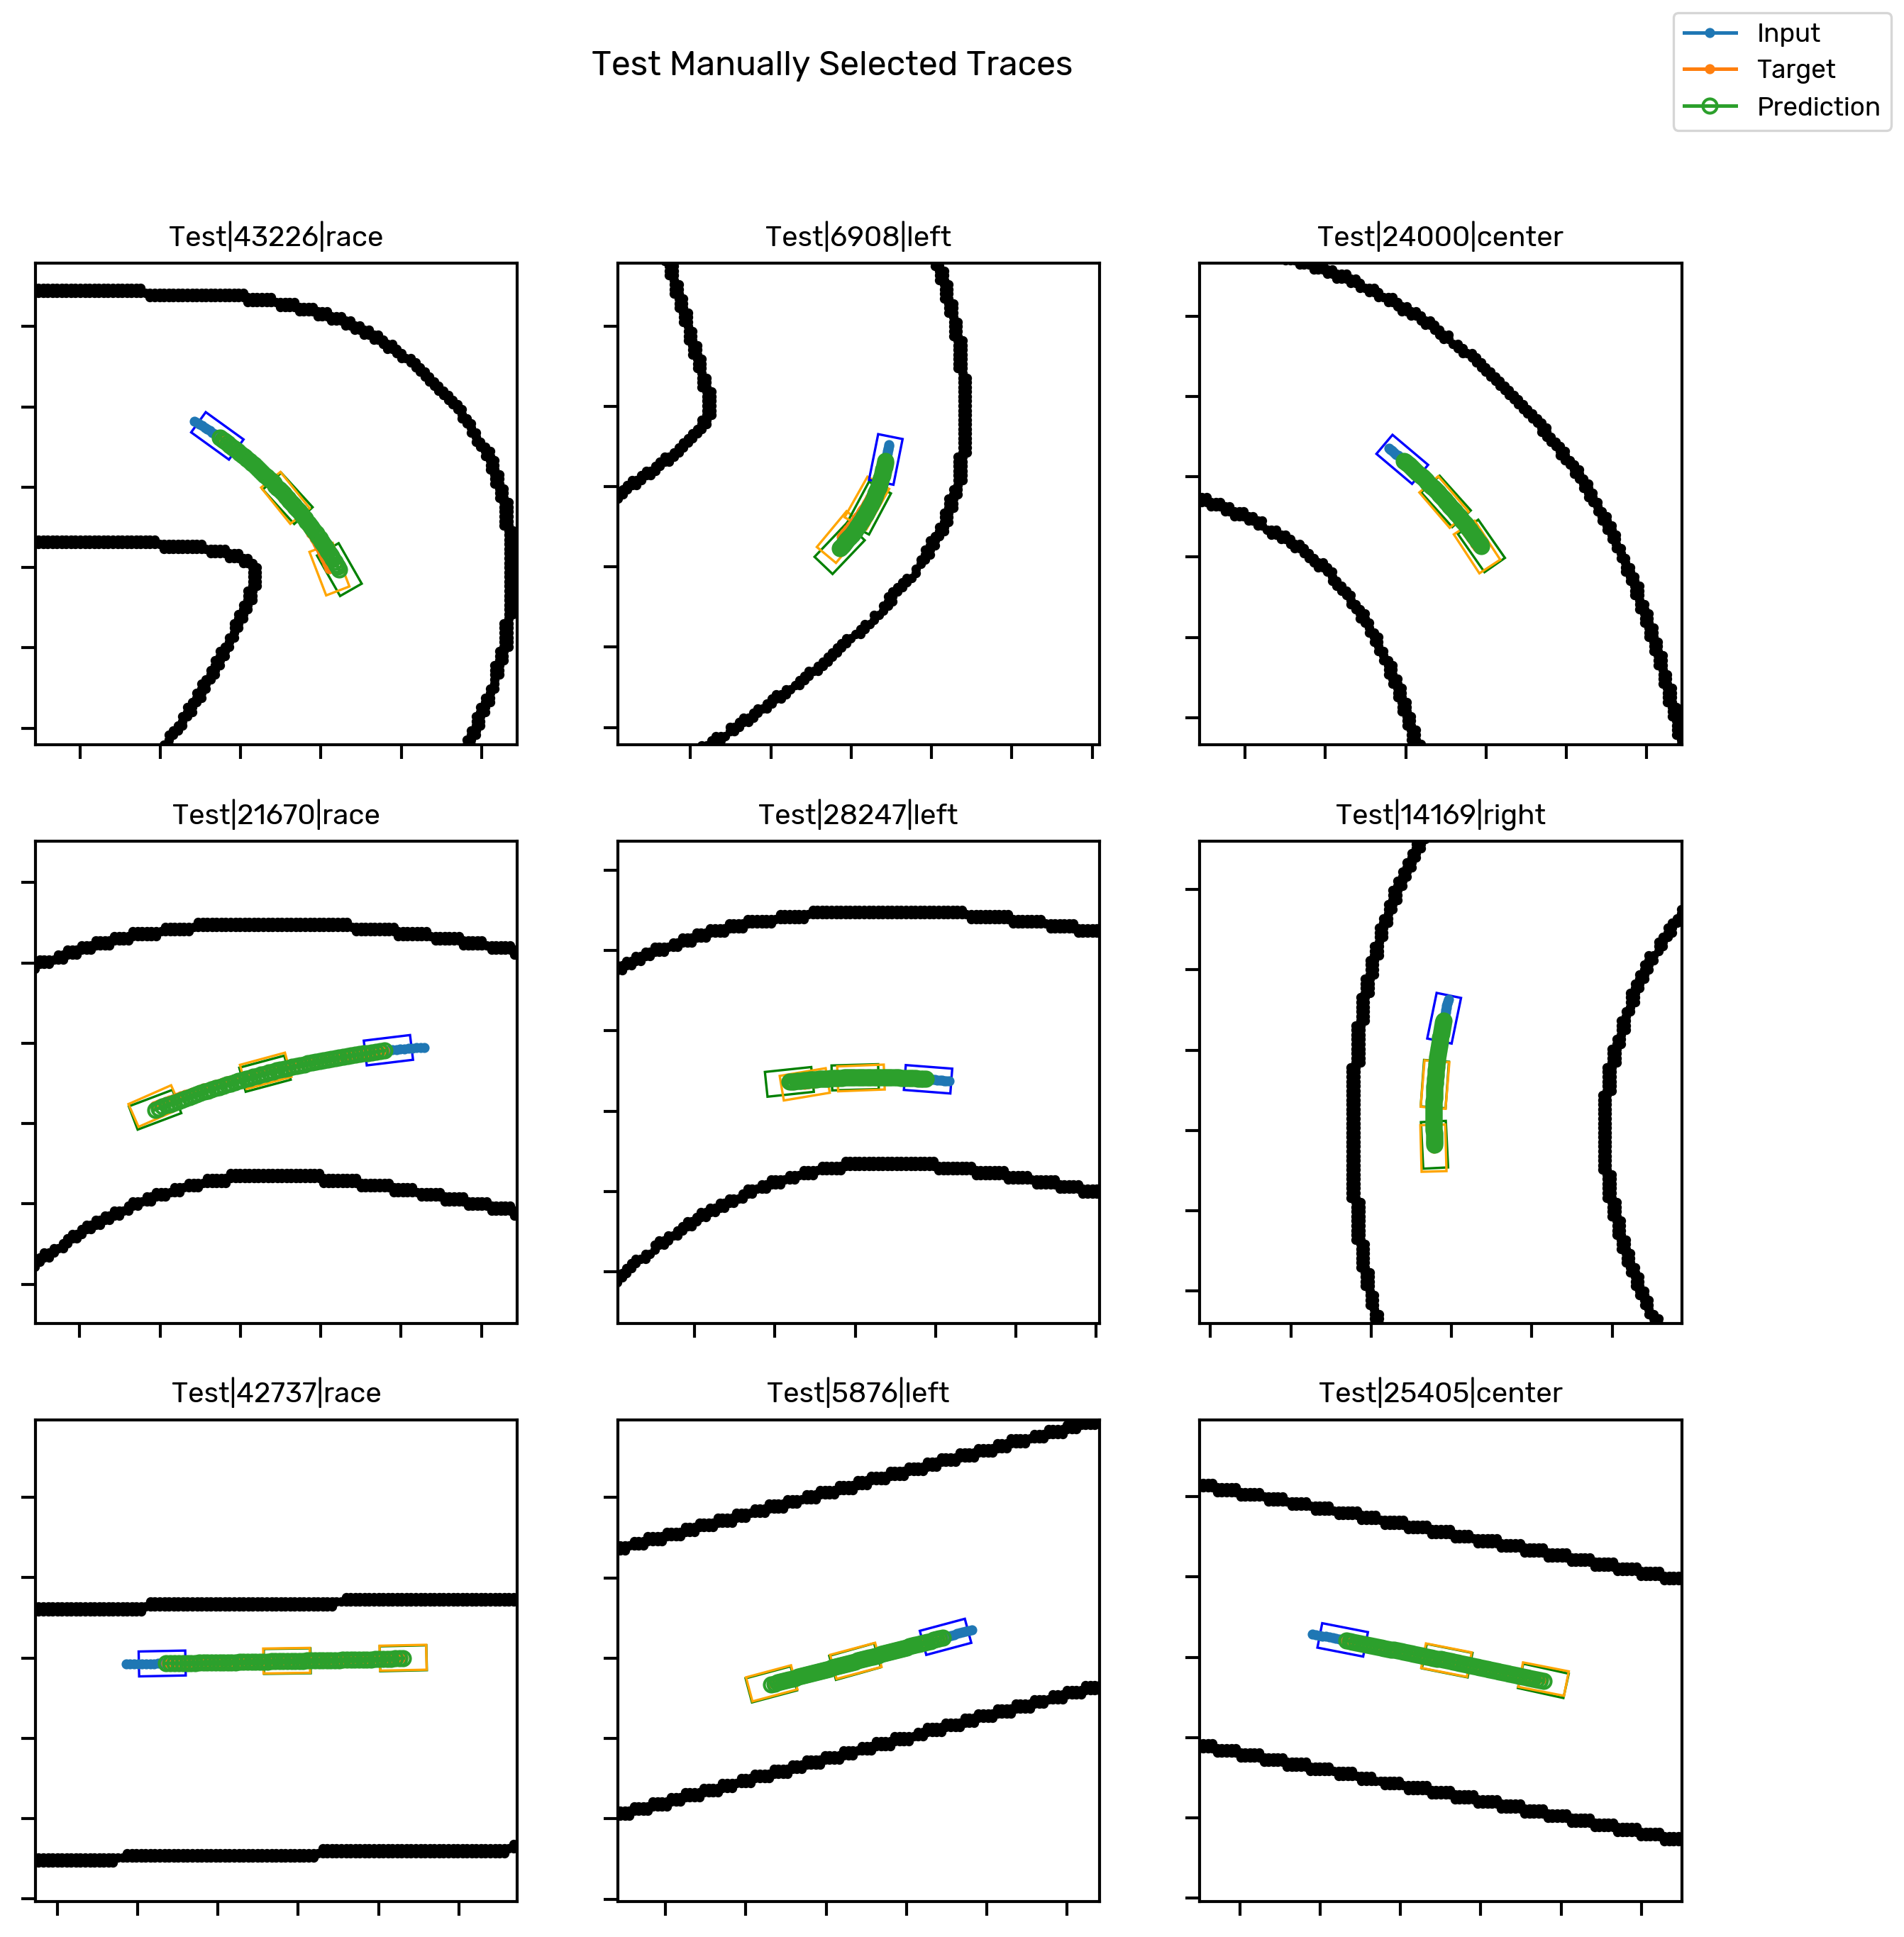

In [9]:
import time
start = time.time()
create_debug_plot(
    net, 
    train_dataset=train_dataloader.dataset, 
    test_dataset=test_dataloader.dataset, 
    val_dataset=val_dataloader.dataset, 
    curvature=config['curvature'], 
    DEVICE=DEVICE, 
    full_frame=full_frame, 
    dataset_name="test"
)
end = time.time()
end-start

0.2676107883453369

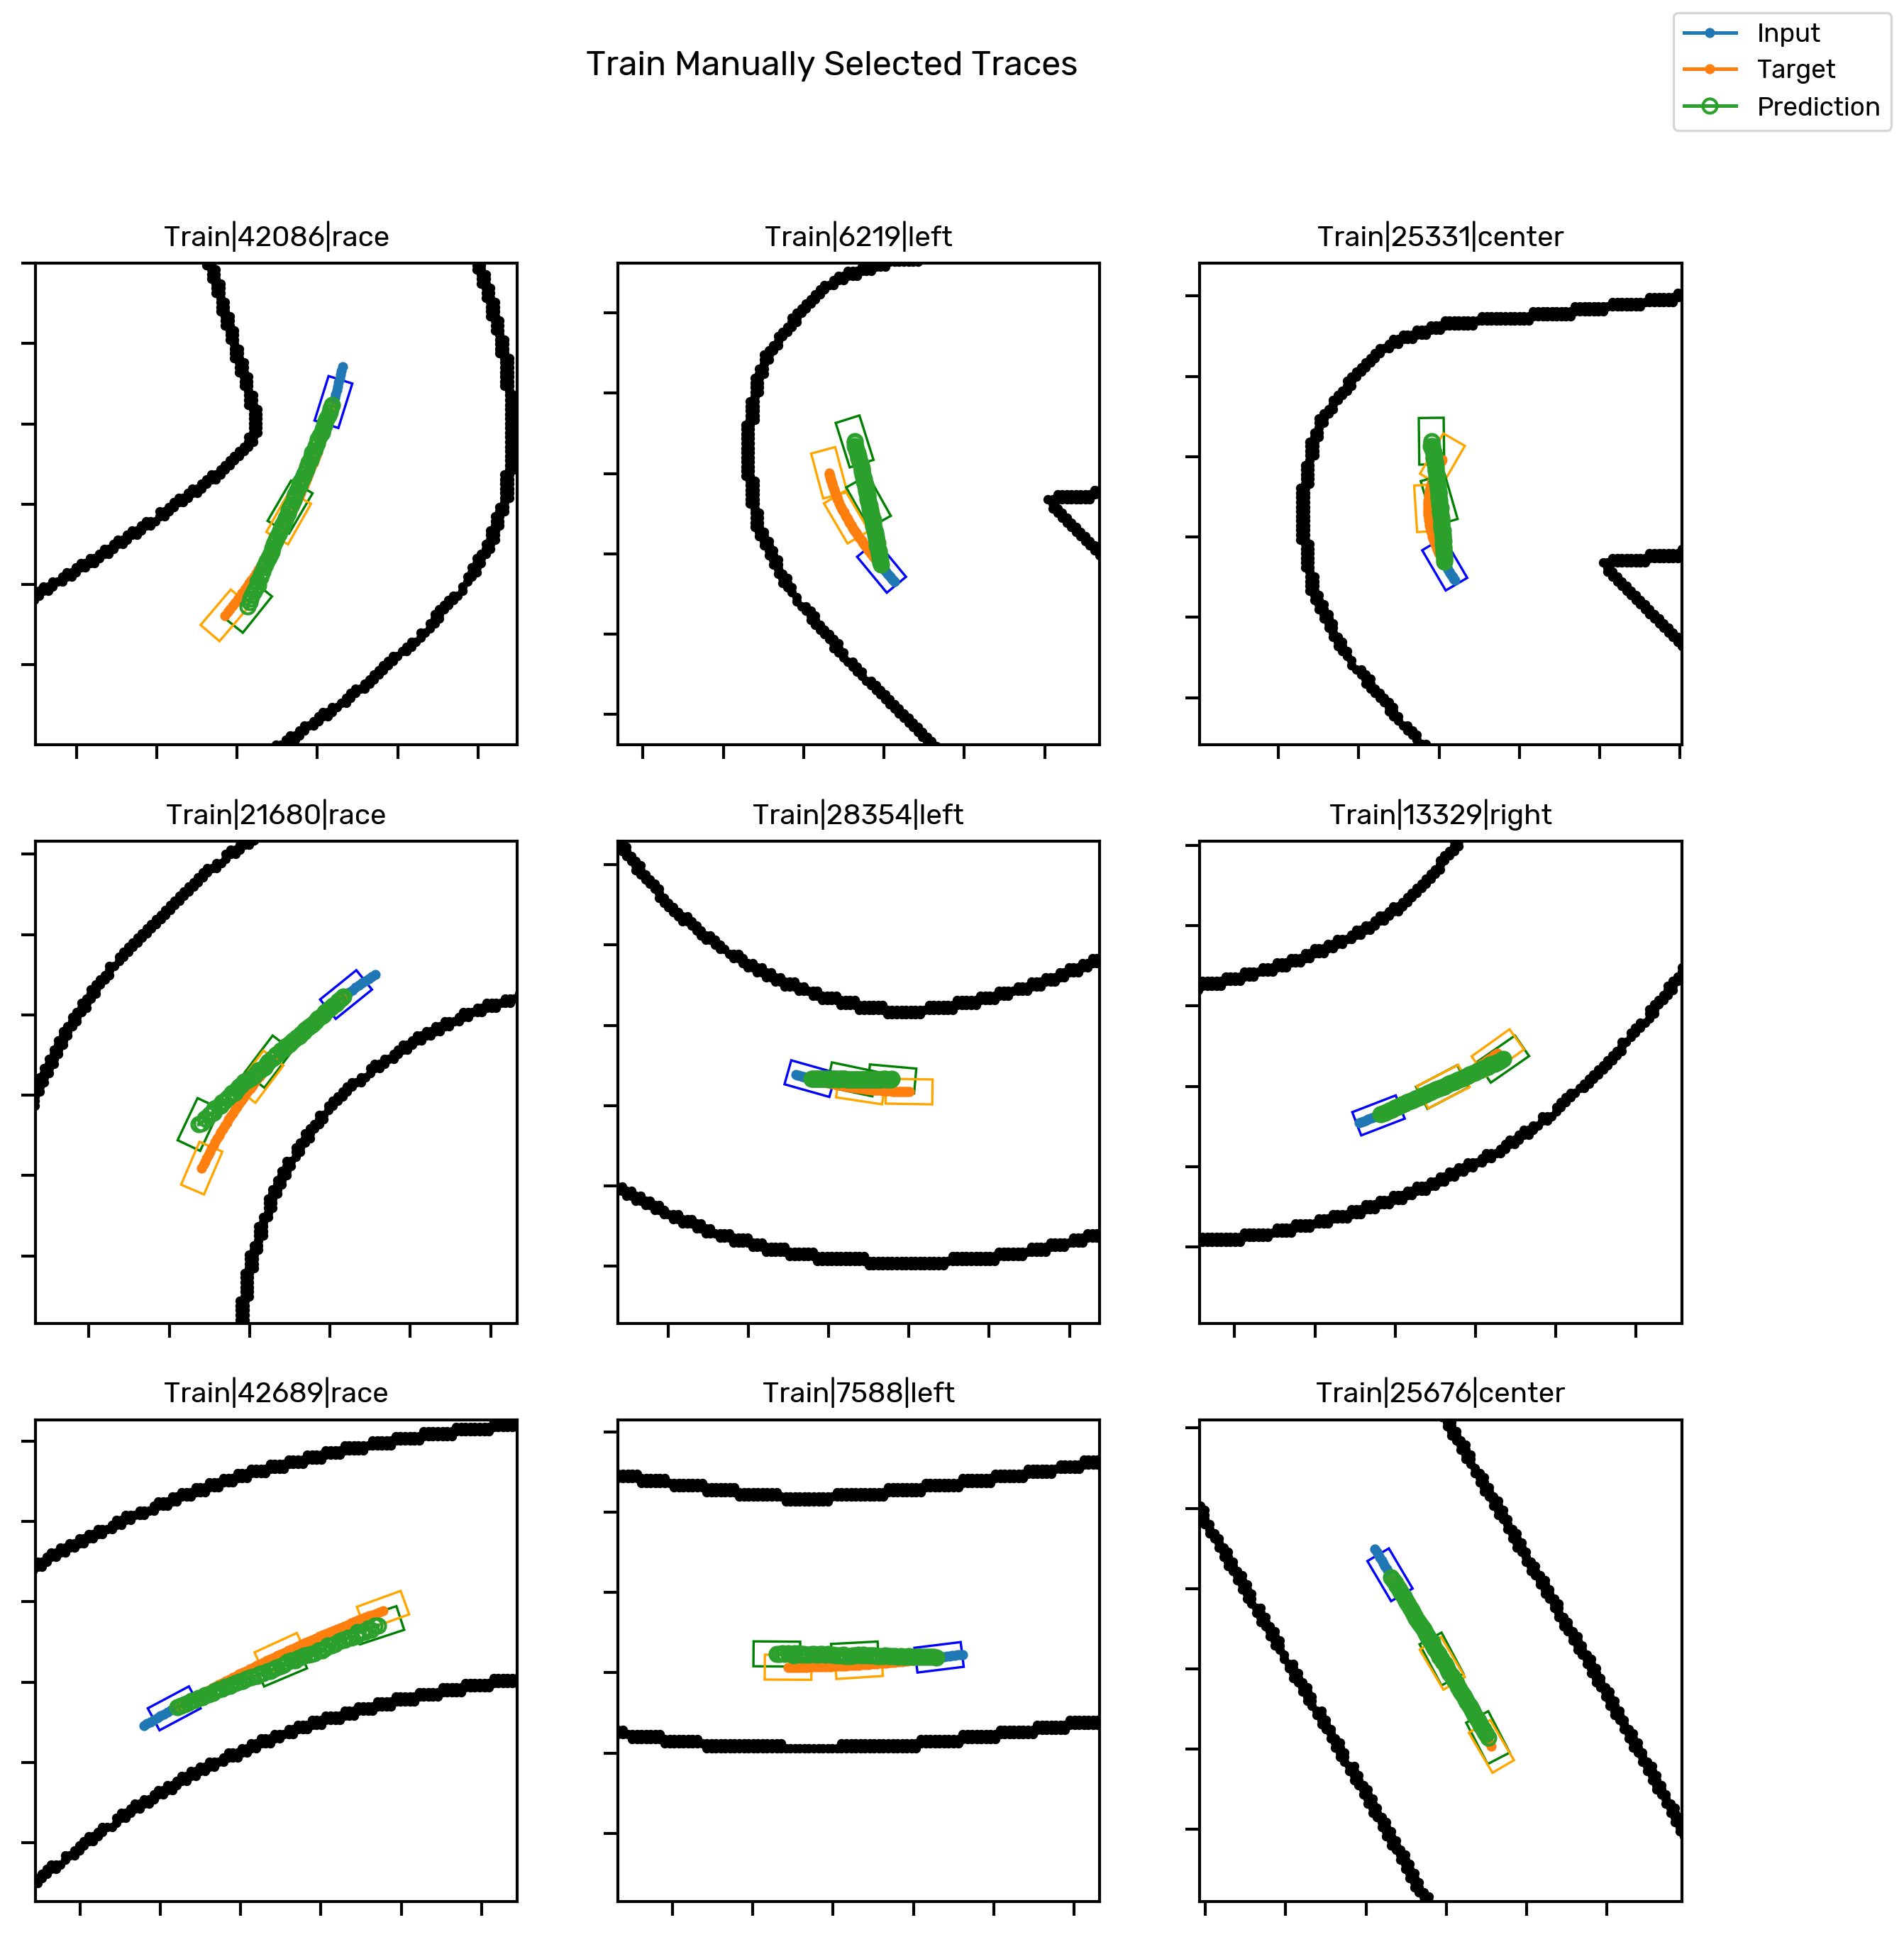

In [10]:
import time
start = time.time()
create_debug_plot(
    lstm_net, 
    train_dataset=train_dataloader.dataset, 
    test_dataset=test_dataloader.dataset, 
    val_dataset=val_dataloader.dataset, 
    curvature=config['curvature'], 
    DEVICE=DEVICE, 
    full_frame=full_frame, 
    dataset_name="train"
)
end = time.time()
end-start

ADE 0.0773358872895751, FDE 0.14824572348506687, HEADING 0.0019680895048753803


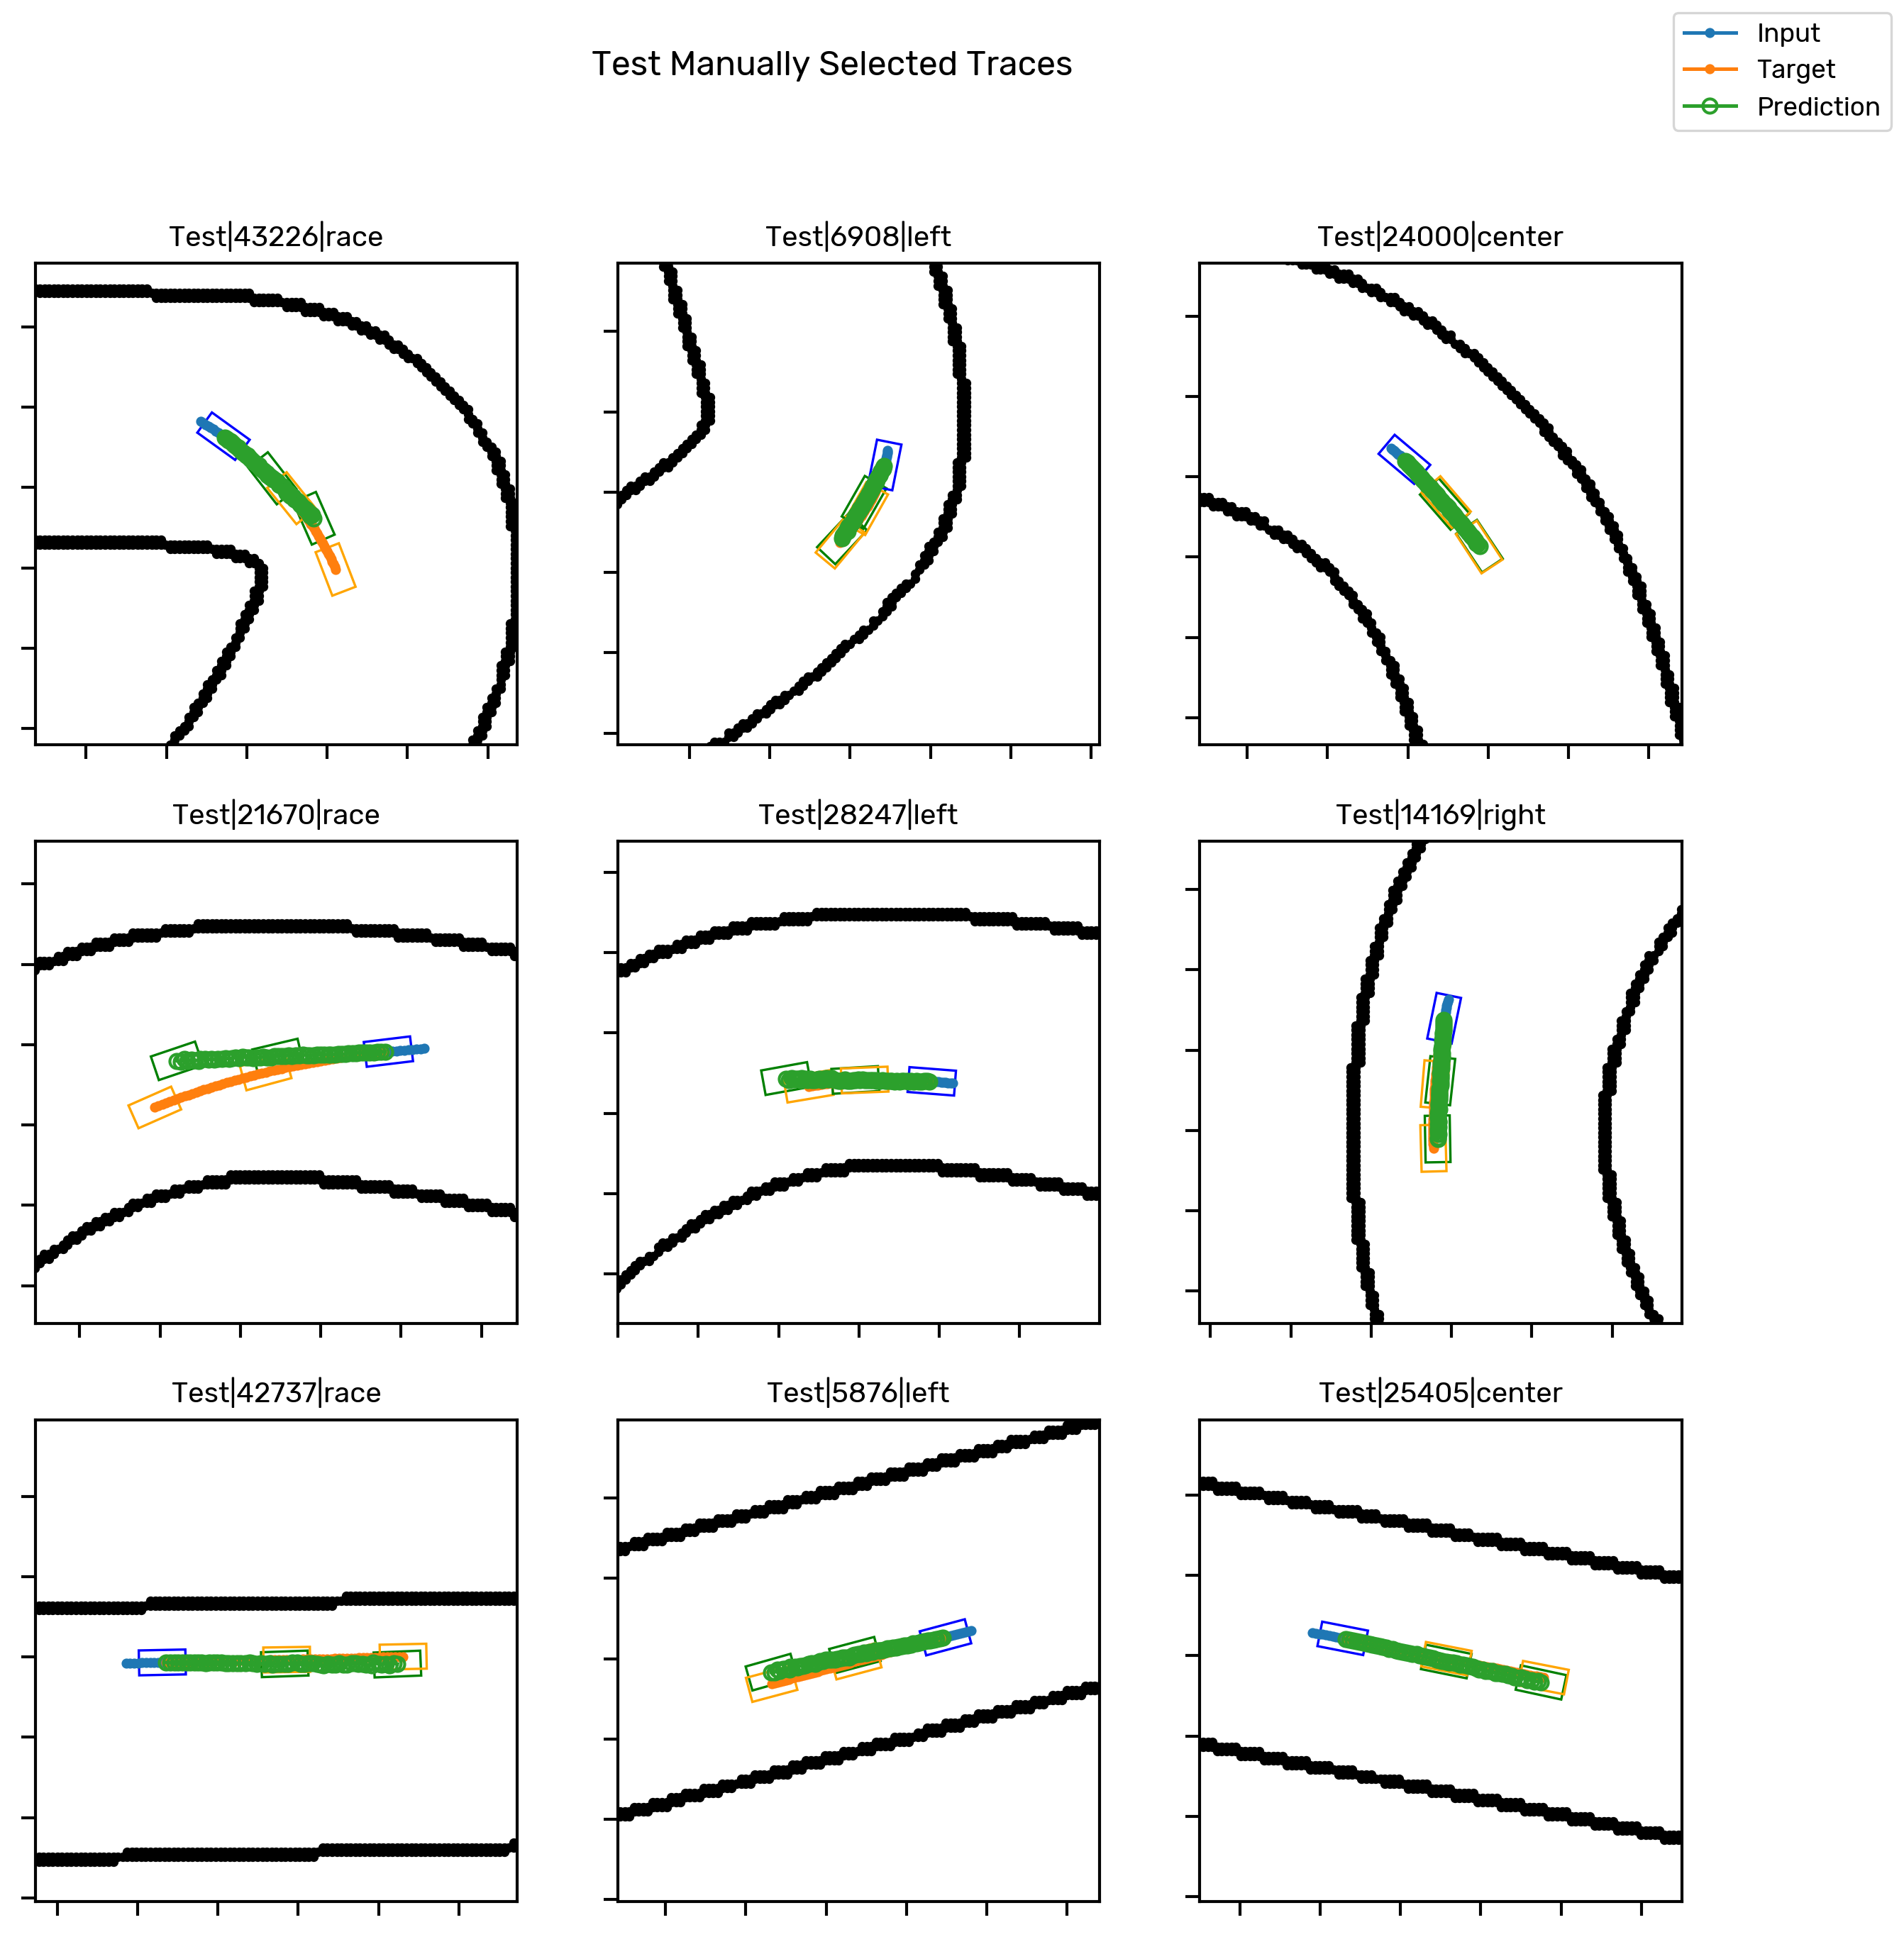

In [11]:
import time
start = time.time()
ade, fde, cum_head_err, iou_err, cum_train_loss, train_fig, end_index, _ = test_model(
                    config_dict=lstm_config_dict,
                    net=lstm_net,
                    dataloader=test_dataloader,
                    loss_func=custom_loss_func,
                    epoch=350,
                    curriculum_steps=1,
                    dataset_name="test",
                    histogram_results=False,
                    iou=False,
                )
end = time.time()
end-start
print(f"ADE {ade}, FDE {fde}, HEADING {cum_head_err}")

ADE 0.04543887711099153, FDE 0.10651961023957088, HEADING 0.002300181182108242


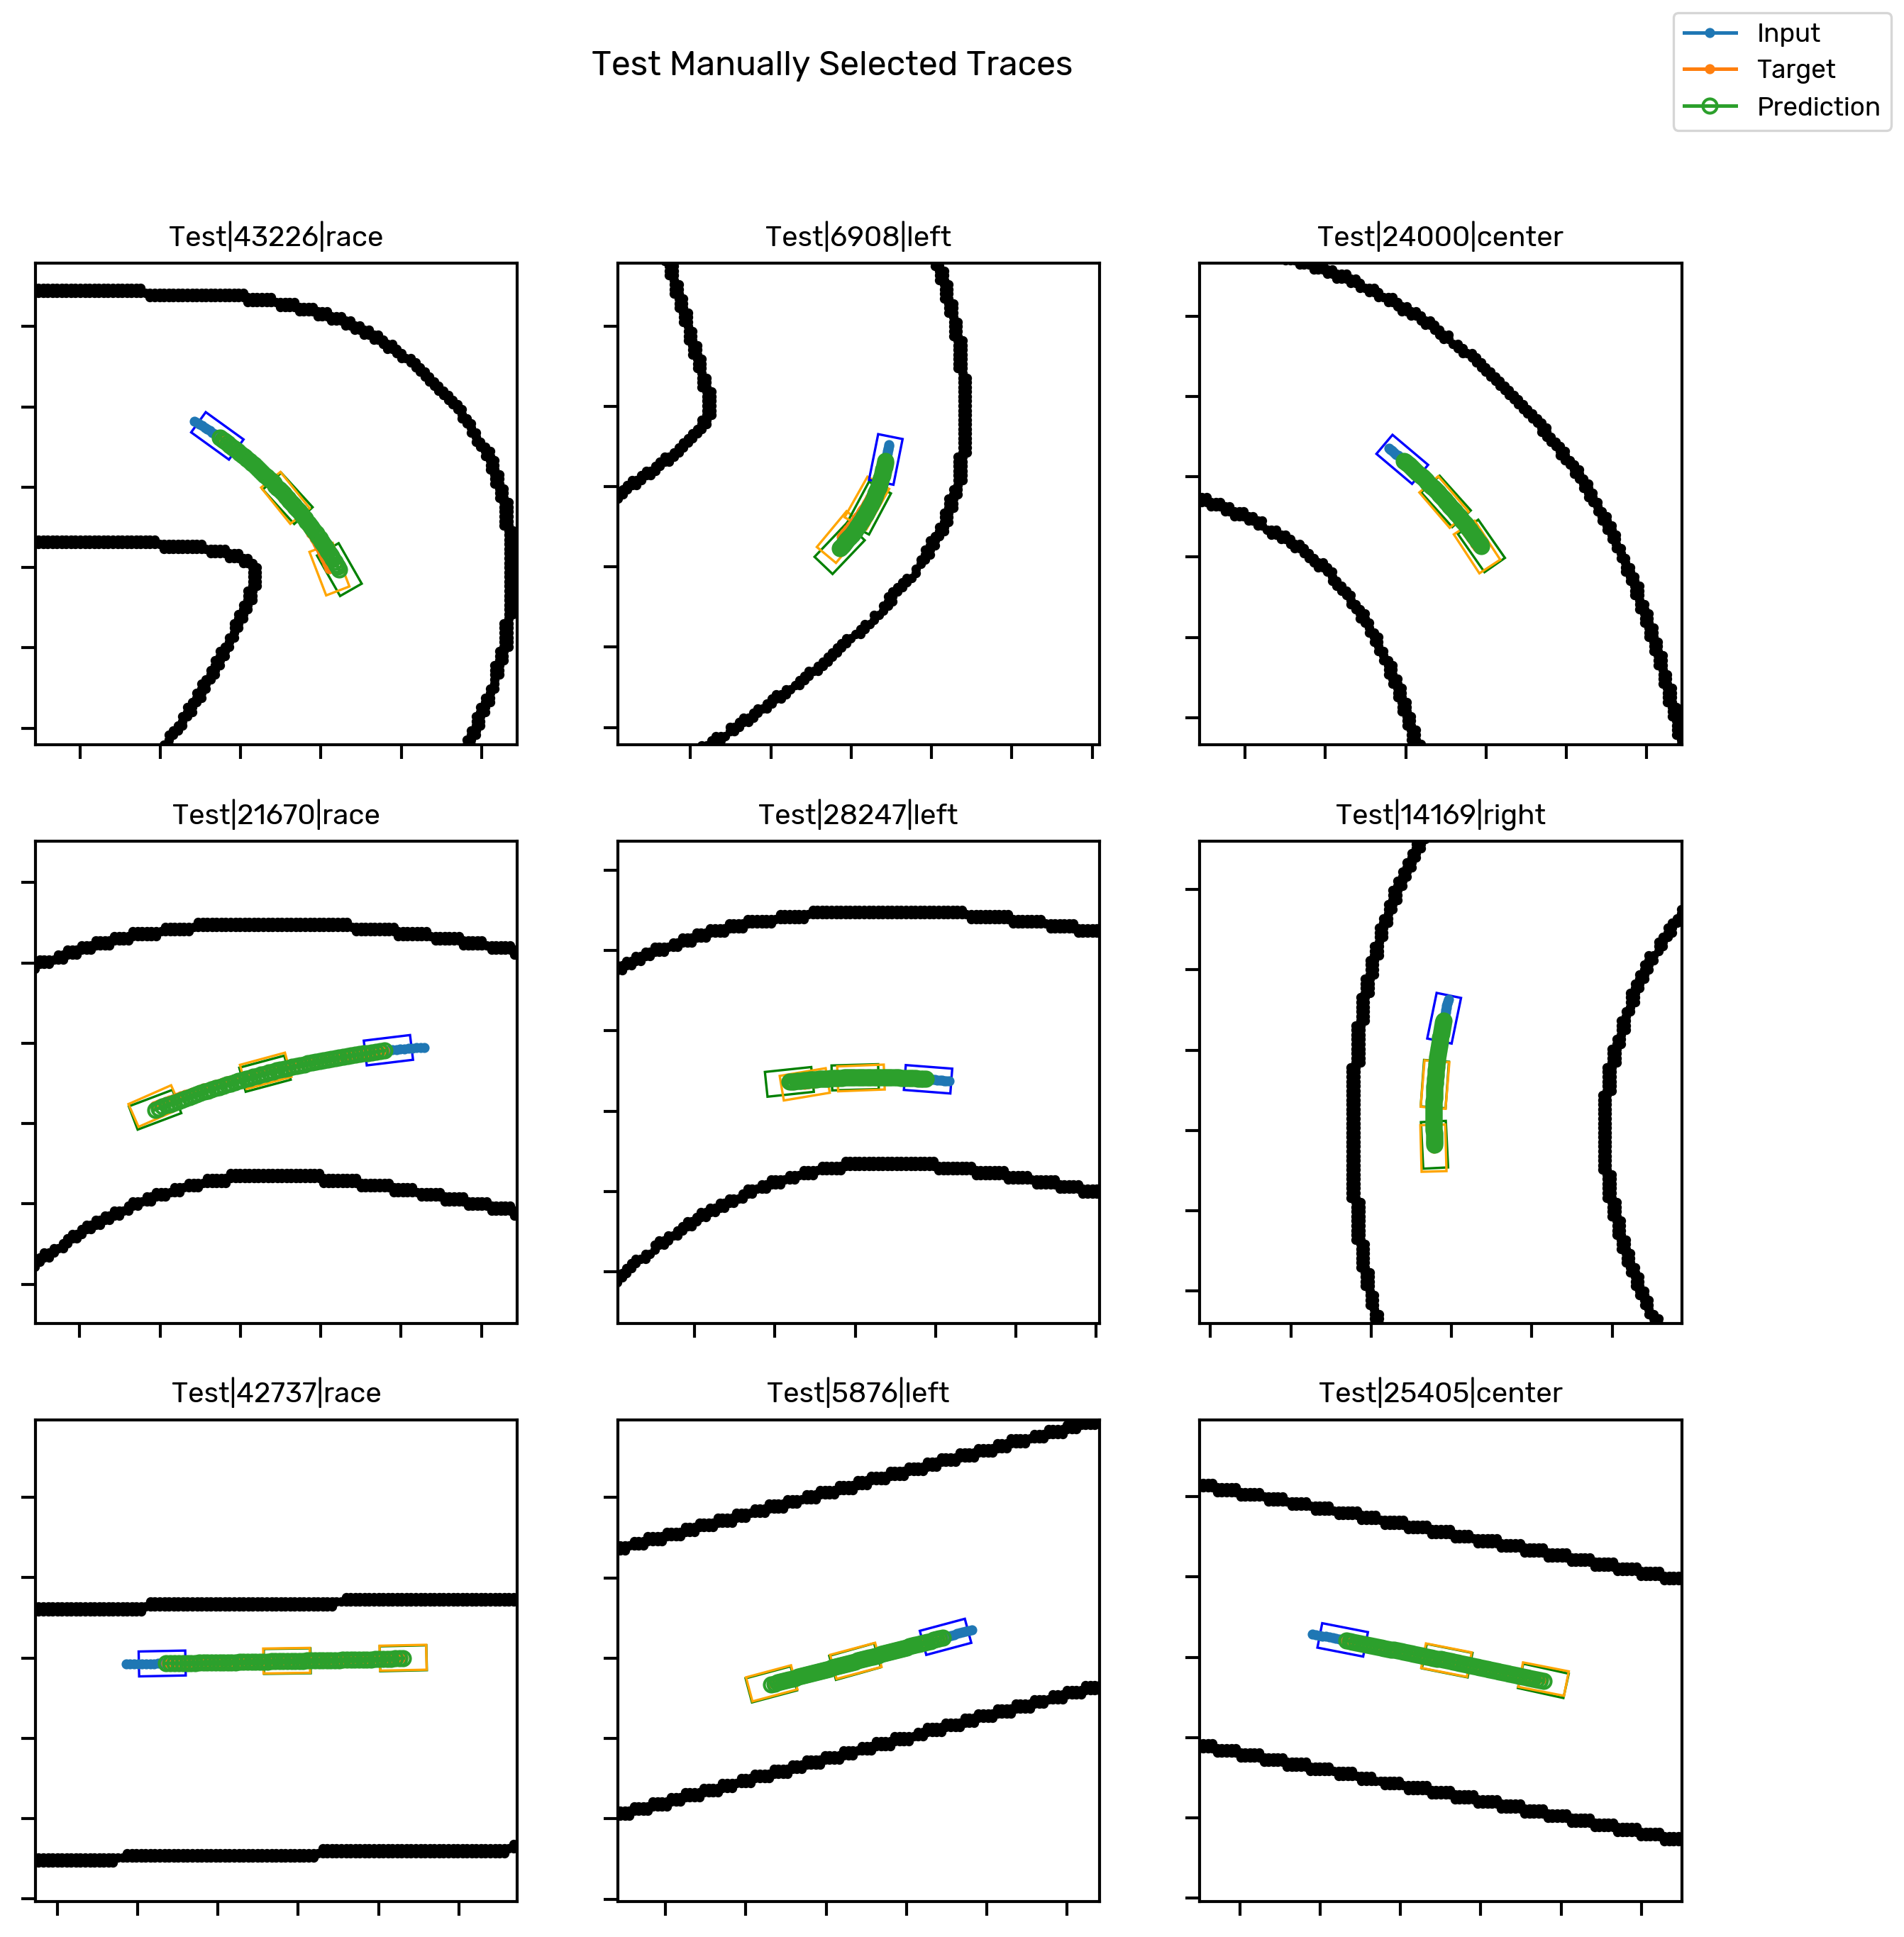

In [12]:
import time
start = time.time()
ade, fde, cum_head_err, iou_err, cum_train_loss, train_fig, end_index, _ = test_model(
                    config_dict=config_dict,
                    net=net,
                    dataloader=test_dataloader,
                    loss_func=custom_loss_func,
                    epoch=350,
                    curriculum_steps=1,
                    dataset_name="test",
                    histogram_results=False,
                    iou=False,
                )
end = time.time()
end-start
print(f"ADE {ade}, FDE {fde}, HEADING {cum_head_err}")

In [13]:
def dimension_displacement_error(prediction, target):
    loss = target[..., :2] - prediction[..., :2]
    return loss

def frenet_error(pred_prog, targ_prog):
    prog_diff = targ_prog - pred_prog
    prog_diff = prog_diff + (1000*(prog_diff<-500)) - (1000*(prog_diff>500))
    if torch.any(prog_diff>500) or torch.any(prog_diff<-500):
        prog_diff = prog_diff + (1000*(prog_diff<-500)) - (1000*(prog_diff>500))
    return prog_diff

In [14]:
def get_rot_matrix(theta, device='cpu'):
    return torch.tensor([
        [torch.cos(theta), -torch.sin(theta)],
        [torch.sin(theta), torch.cos(theta)]
    ], device=device)

def rotate_sample(input, last_pose, target, output):
    rot_target = get_rot_matrix(-last_pose[2])@((target[..., :2]-last_pose[:2]).T)
    rot_input = get_rot_matrix(-last_pose[2])@((input[..., :2]-last_pose[:2]).T)
    rot_output = get_rot_matrix(-last_pose[2])@((output[..., :2]-last_pose[:2]).T)
    return rot_input.T, rot_target.T, rot_output.T

def convert_line(line):
    return torch.tensor(np.array([point_to_frenet(line[i], centerline) for i in range(len(line))]))

In [15]:
control_input_bias = torch.cat([0.00*torch.ones((60,1)), torch.zeros((60,1))], 1).to(DEVICE)

def get_error_dictionary(dataloader: DataLoader):
    lstm_ades = list()
    lstm_fdes = list()
    lstm_errors = list()
    disp_errors = list()
    dim_disp_errors = list()
    rotated_dim_disp_errors = list()
    frenet_disp_errors = list()

    net.eval()
    for input, last_pose, target in tqdm(dataloader):
        with torch.no_grad():
            input = input.to(DEVICE)
            last_pose = last_pose
            target = target.to(DEVICE)
            output, control_outputs = net.predict(input, last_pose, control_input_bias=control_input_bias)
            disp_errors.append(displacement_error(output, target))
            dim_disp_errors.append(dimension_displacement_error(output, target))
            for i in tqdm(range(input.shape[0]), leave=False):
                rot_input, rot_target, rot_output = rotate_sample(input[i].to('cpu'), last_pose[i], target[i].to('cpu'), output[i].to('cpu'))
                rotated_dim_disp_errors.append(dimension_displacement_error(rot_output, rot_target).unsqueeze(0))
                frenet_target = convert_line(target[i,...,:2].cpu().numpy())
                frenet_output = convert_line(output[i,...,:2].cpu().numpy())
                fren_error = dimension_displacement_error(frenet_output, frenet_target)
                fren_error[..., 0] = frenet_error(frenet_target[..., 0], frenet_output[..., 0])
                if torch.any(fren_error[..., 0]>500) or torch.any(fren_error[..., 0]<-500):
                    print(np.array(fren_error[..., 0], dtype=int))
                    raise ValueError
                frenet_disp_errors.append(fren_error.unsqueeze(0))


    disp_errors = torch.vstack(disp_errors).to("cpu")
    dim_disp_errors = torch.vstack(dim_disp_errors).to("cpu")
    rotated_dim_disp_errors = torch.vstack(rotated_dim_disp_errors).to("cpu")
    frenet_disp_errors = torch.vstack(frenet_disp_errors).to("cpu")
    errors = {
        'disp_errors': disp_errors,
        'dim_disp_errors': dim_disp_errors,
        'rotated_dim_disp_errors': rotated_dim_disp_errors,
        'frenet_disp_errors': frenet_disp_errors,
    }
    return errors

In [16]:
train_errors = get_error_dictionary(train_dataloader)
val_errors = get_error_dictionary(val_dataloader)
test_errors = get_error_dictionary(test_dataloader)

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/894 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

## Conformalized Quantile Regression

In [122]:
delta = 0.05
delta_bar = delta/train_errors['disp_errors'].shape[1]
print(train_errors['disp_errors'].shape[1])
quantile_target = (1-(delta_bar)) * (1+(1/len(val_dataloader.dataset)))
quantile_target

60


0.9993971017835178

In [123]:
displacement_errors = {
    'train_errors': train_errors['disp_errors'],
    'val_errors': val_errors['disp_errors'],
    'test_errors': test_errors['disp_errors'],
}
rectangle_errors = {
    'train_x_errors': train_errors['dim_disp_errors'][..., 0],
    'val_x_errors': val_errors['dim_disp_errors'][..., 0],
    'test_x_errors': test_errors['dim_disp_errors'][..., 0],
    'train_y_errors': train_errors['dim_disp_errors'][..., 1],
    'val_y_errors': val_errors['dim_disp_errors'][..., 1],
    'test_y_errors': test_errors['dim_disp_errors'][..., 1],
}
rotated_rectangle_errors = {
    'train_x_errors': train_errors['rotated_dim_disp_errors'][..., 0],
    'val_x_errors': val_errors['rotated_dim_disp_errors'][..., 0],
    'test_x_errors': test_errors['rotated_dim_disp_errors'][..., 0],
    'train_y_errors': train_errors['rotated_dim_disp_errors'][..., 1],
    'val_y_errors': val_errors['rotated_dim_disp_errors'][..., 1],
    'test_y_errors': test_errors['rotated_dim_disp_errors'][..., 1],
}
frenet_errors = {
    'train_prog_errors': train_errors['frenet_disp_errors'][..., 0],
    'val_prog_errors': val_errors['frenet_disp_errors'][..., 0],
    'test_prog_errors': test_errors['frenet_disp_errors'][..., 0],
    'train_disp_errors': train_errors['frenet_disp_errors'][..., 1],
    'val_disp_errors': val_errors['frenet_disp_errors'][..., 1],
    'test_disp_errors': test_errors['frenet_disp_errors'][..., 1],
}

In [124]:
# Quantiles on training data
displacement_quantiles = {
    'lower': displacement_errors['train_errors'].quantile(delta_bar/2, dim=0, interpolation='lower'),
    'upper': displacement_errors['train_errors'].quantile((1-(delta_bar/2)), dim=0, interpolation='higher'),
}

rectangle_quantiles = {
    'x_lower': rectangle_errors['train_x_errors'].quantile(delta_bar/2, dim=0, interpolation='lower'),
    'x_upper': rectangle_errors['train_x_errors'].quantile((1-(delta_bar/2)), dim=0, interpolation='higher'),
    'y_lower': rectangle_errors['train_y_errors'].quantile(delta_bar/2, dim=0, interpolation='lower'),
    'y_upper': rectangle_errors['train_y_errors'].quantile((1-(delta_bar/2)), dim=0, interpolation='higher'),
}
rotated_rectangle_quantiles = {
    'x_lower': rotated_rectangle_errors['train_x_errors'].quantile(delta_bar/2, dim=0, interpolation='lower'),
    'x_upper': rotated_rectangle_errors['train_x_errors'].quantile((1-(delta_bar/2)), dim=0, interpolation='higher'),
    'y_lower': rotated_rectangle_errors['train_y_errors'].quantile(delta_bar/2, dim=0, interpolation='lower'),
    'y_upper': rotated_rectangle_errors['train_y_errors'].quantile((1-(delta_bar/2)), dim=0, interpolation='higher'),
}
frenet_quantiles = {
    'prog_lower': frenet_errors['train_prog_errors'].quantile(delta_bar/2, dim=0, interpolation='lower'),
    'prog_upper': frenet_errors['train_prog_errors'].quantile((1-(delta_bar/2)), dim=0, interpolation='higher'),
    'disp_lower': frenet_errors['train_disp_errors'].quantile(delta_bar/2, dim=0, interpolation='lower'),
    'disp_upper': frenet_errors['train_disp_errors'].quantile((1-(delta_bar/2)), dim=0, interpolation='higher'),
}

In [125]:
frenet_quantiles['disp_lower']

tensor([-0.0341, -0.0344, -0.0342, -0.0345, -0.0361, -0.0389, -0.0449, -0.0503,
        -0.0538, -0.0623, -0.0709, -0.0803, -0.0908, -0.1040, -0.1155, -0.1314,
        -0.1479, -0.1673, -0.1829, -0.2021, -0.2214, -0.2456, -0.2703, -0.2972,
        -0.3251, -0.3477, -0.3699, -0.4045, -0.4268, -0.4593, -0.4987, -0.5247,
        -0.5575, -0.5922, -0.6228, -0.6555, -0.6894, -0.7246, -0.7606, -0.7970,
        -0.8333, -0.8682, -0.9042, -0.9404, -0.9772, -1.0131, -1.0500, -1.0899,
        -1.1288, -1.1681, -1.2066, -1.2461, -1.2844, -1.3241, -1.3634, -1.4038,
        -1.4455, -1.4866, -1.5295, -1.5737], dtype=torch.float64)

In [126]:
frenet_errors['train_disp_errors'].quantile((1-(delta/2)), dim=0)

tensor([0.0196, 0.0196, 0.0198, 0.0201, 0.0202, 0.0205, 0.0208, 0.0214, 0.0219,
        0.0225, 0.0232, 0.0240, 0.0248, 0.0257, 0.0265, 0.0276, 0.0287, 0.0299,
        0.0311, 0.0324, 0.0344, 0.0360, 0.0377, 0.0392, 0.0415, 0.0434, 0.0451,
        0.0473, 0.0490, 0.0510, 0.0538, 0.0566, 0.0588, 0.0613, 0.0637, 0.0663,
        0.0692, 0.0715, 0.0742, 0.0769, 0.0799, 0.0829, 0.0860, 0.0891, 0.0924,
        0.0950, 0.0980, 0.1009, 0.1045, 0.1083, 0.1113, 0.1152, 0.1190, 0.1224,
        0.1253, 0.1281, 0.1316, 0.1348, 0.1384, 0.1419], dtype=torch.float64)

In [127]:
frenet_quantiles['disp_upper']

tensor([0.0331, 0.0337, 0.0342, 0.0353, 0.0362, 0.0364, 0.0373, 0.0394, 0.0420,
        0.0481, 0.0557, 0.0635, 0.0742, 0.0906, 0.1034, 0.1160, 0.1250, 0.1425,
        0.1584, 0.1755, 0.1982, 0.2184, 0.2388, 0.2619, 0.2823, 0.3039, 0.3255,
        0.3555, 0.3739, 0.3991, 0.4250, 0.4541, 0.4783, 0.5074, 0.5373, 0.5688,
        0.6013, 0.6364, 0.6658, 0.6988, 0.7330, 0.7640, 0.7933, 0.8229, 0.8545,
        0.8852, 0.9149, 0.9510, 0.9898, 1.0292, 1.0696, 1.1099, 1.1409, 1.1887,
        1.1963, 1.2231, 1.2496, 1.2762, 1.3027, 1.3283], dtype=torch.float64)

In [128]:
torch.maximum(
    torch.ones_like(displacement_errors['val_errors'])*displacement_quantiles['lower'] - displacement_errors['val_errors'],
    displacement_errors['val_errors'] - torch.ones_like(displacement_errors['val_errors'])*displacement_quantiles['upper'],
).quantile(quantile_target, dim=0)

tensor([ 4.0564e-05, -5.2061e-05,  9.7500e-05, -8.9315e-05,  6.7876e-05,
         1.1632e-04, -1.4864e-05,  5.9617e-04,  1.3436e-04,  5.1955e-05,
        -6.5882e-05, -9.1668e-05,  7.9346e-05,  1.0909e-04,  6.3875e-05,
         1.5831e-03,  4.2746e-03,  4.5663e-03,  5.1368e-03,  6.4141e-03,
         6.7712e-03,  7.3517e-03,  7.8302e-03,  8.0020e-03,  7.8735e-03,
         8.0901e-03,  8.7987e-03,  8.3457e-03,  7.6078e-03,  7.6477e-03,
         8.3991e-03,  7.8060e-03,  7.1682e-03,  6.7296e-03,  5.9518e-03,
         5.4049e-03,  4.3834e-03,  2.2415e-03,  3.7673e-04,  1.8511e-04,
         4.0373e-04,  4.0680e-04,  5.0020e-04,  5.8088e-04,  4.5398e-04,
        -7.4268e-05, -1.6721e-04, -1.1882e-04, -2.4615e-04, -2.0206e-04,
         1.0067e-04, -3.2029e-04, -7.7538e-05, -6.3554e-05,  3.0067e-04,
         5.8469e-04,  4.0383e-04,  5.8984e-04,  5.4782e-04,  3.8333e-04])

In [129]:
# Conformity Score Calculation
displacement_conformity_scores = {
    'E': torch.maximum(
        displacement_quantiles['lower'] - displacement_errors['val_errors'],
        displacement_errors['val_errors'] - displacement_quantiles['upper'],
    ),
}
rectangle_conformity_scores = {
    'E_x': torch.maximum(
        rectangle_quantiles['x_lower'] - rectangle_errors['val_x_errors'],
        rectangle_errors['val_x_errors'] - rectangle_quantiles['x_upper'],
    ),
    'E_y': torch.maximum(
        rectangle_quantiles['y_lower'] - rectangle_errors['val_y_errors'],
        rectangle_errors['val_y_errors'] - rectangle_quantiles['y_upper'],
    ),
}
rotated_rectangle_conformity_scores = {
    'E_x': torch.maximum(
        rotated_rectangle_quantiles['x_lower'] - rotated_rectangle_errors['val_x_errors'],
        rotated_rectangle_errors['val_x_errors'] - rotated_rectangle_quantiles['x_upper'],
    ),
    'E_y': torch.maximum(
        rotated_rectangle_quantiles['y_lower'] - rotated_rectangle_errors['val_y_errors'],
        rotated_rectangle_errors['val_y_errors'] - rotated_rectangle_quantiles['y_upper'],
    ),
}
frenet_conformity_scores = {
    'E_prog': torch.maximum(
        frenet_quantiles['prog_lower'] - frenet_errors['val_prog_errors'],
        frenet_errors['val_prog_errors'] - frenet_quantiles['prog_upper'],
    ),
    'E_disp': torch.maximum(
        frenet_quantiles['disp_lower'] - frenet_errors['val_disp_errors'],
        frenet_errors['val_disp_errors'] - frenet_quantiles['disp_upper'],
    ),
}

In [130]:
# Prediction Region Calculation
displacement_region = {
    'lower': displacement_quantiles['lower'] - displacement_conformity_scores['E'].quantile(quantile_target, dim=0, interpolation='higher'),
    'upper': displacement_quantiles['upper'] + displacement_conformity_scores['E'].quantile(quantile_target, dim=0, interpolation='higher'),
}
rectangle_region = {
    'x_lower': rectangle_quantiles['x_lower'] - rectangle_conformity_scores['E_x'].quantile(quantile_target, dim=0, interpolation='higher'),
    'x_upper': rectangle_quantiles['x_upper'] + rectangle_conformity_scores['E_x'].quantile(quantile_target, dim=0, interpolation='higher'),
    'y_lower': rectangle_quantiles['y_lower'] - rectangle_conformity_scores['E_y'].quantile(quantile_target, dim=0, interpolation='higher'),
    'y_upper': rectangle_quantiles['y_upper'] + rectangle_conformity_scores['E_y'].quantile(quantile_target, dim=0, interpolation='higher'),
}
rotated_rectangle_region = {
    'x_lower': rectangle_quantiles['x_lower'] - rectangle_conformity_scores['E_x'].quantile(quantile_target, dim=0, interpolation='higher'),
    'x_upper': rectangle_quantiles['x_upper'] + rectangle_conformity_scores['E_x'].quantile(quantile_target, dim=0, interpolation='higher'),
    'y_lower': rectangle_quantiles['y_lower'] - rectangle_conformity_scores['E_y'].quantile(quantile_target, dim=0, interpolation='higher'),
    'y_upper': rectangle_quantiles['y_upper'] + rectangle_conformity_scores['E_y'].quantile(quantile_target, dim=0, interpolation='higher'),
}
frenet_region = {
    'prog_lower': frenet_quantiles['prog_lower'] - frenet_conformity_scores['E_prog'].quantile(quantile_target, dim=0, interpolation='higher'),
    'prog_upper': frenet_quantiles['prog_upper'] + frenet_conformity_scores['E_prog'].quantile(quantile_target, dim=0, interpolation='higher'),
    'disp_lower': frenet_quantiles['disp_lower'] - frenet_conformity_scores['E_disp'].quantile(quantile_target, dim=0, interpolation='higher'),
    'disp_upper': frenet_quantiles['disp_upper'] + frenet_conformity_scores['E_disp'].quantile(quantile_target, dim=0, interpolation='higher'),
}
displacement_region = {
    'upper': displacement_errors['train_errors'].quantile(quantile_target, dim=0, interpolation='higher'),
}


## Coverage Verification

### Displacement

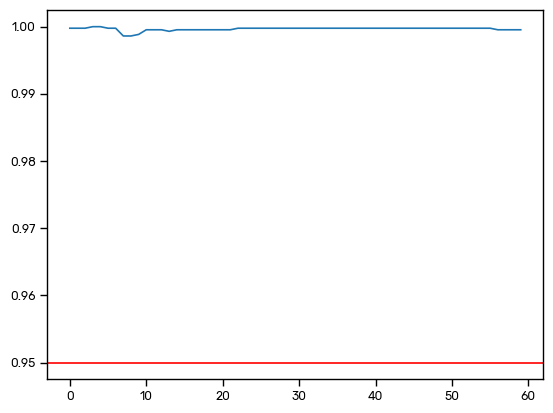

In [131]:
# Verify Quantiles
# This is the Single Step Coverage
displacement_coverage = torch.hstack(
    [torch.sum((displacement_errors['test_errors'][:,i]<=displacement_region['upper'][i]))/(displacement_errors['test_errors'][:,i]).numel() for i in range(displacement_errors['test_errors'].shape[1])]
)
plt.plot(displacement_coverage)
plt.axhline(1-delta, color='red')

In [132]:
# # Verify Quantiles - Single Step Coverage - Not Valid
# displacement_coverage = torch.logical_and(
#     (displacement_region['lower']<=displacement_errors['test_errors']),
#     (displacement_errors['test_errors']<=displacement_region['upper'])
# )
# displacement_coverage = torch.hstack([torch.sum(displacement_coverage[:,i])/displacement_coverage[:,i].numel() for i in range(displacement_coverage.shape[1])])
# #rectangle_dual_coverage = rectangle_dual_coverage.sum()/rectangle_dual_coverage.numel()
# plt.plot(displacement_coverage)
# plt.axhline(1-delta, color='red')

In [133]:
# This is the Multi-Step Coverage
# First step identifies coverage failures
displacement_coverage = (displacement_errors['test_errors']<=displacement_region['upper'])
# Batch them by failed trajectories
displacement_coverage = torch.hstack([torch.all(displacement_coverage[i]) for i in range(displacement_coverage.shape[0])])
# Divide by total trajectories
displacement_coverage = displacement_coverage.sum()/displacement_coverage.numel()
#displacement_coverage = torch.sum((displacement_errors['test_errors']<=displacement_region['upper']))/(displacement_errors['test_errors']).numel()
displacement_coverage

tensor(0.9977)

### Rectangle

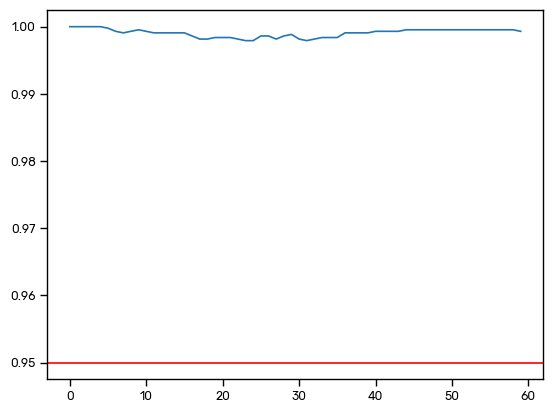

In [134]:
# Verify Quantiles - Single Step Coverage
rectangle_dual_coverage = torch.logical_and(
    torch.logical_and(
        (rectangle_region['x_lower']<=rectangle_errors['test_x_errors']),
        (rectangle_errors['test_x_errors']<=rectangle_region['x_upper'])
    ),
    torch.logical_and(
        (rectangle_region['y_lower']<=rectangle_errors['test_y_errors']),
        (rectangle_errors['test_y_errors']<=rectangle_region['y_upper'])
    ),
)
rectangle_dual_coverage = torch.hstack([torch.sum(rectangle_dual_coverage[:,i])/rectangle_dual_coverage[:,i].numel() for i in range(rectangle_dual_coverage.shape[1])])
#rectangle_dual_coverage = rectangle_dual_coverage.sum()/rectangle_dual_coverage.numel()
plt.plot(rectangle_dual_coverage)
plt.axhline(1-delta, color='red')

In [135]:
# Verify Quantiles - Multi-Step Coverage
rectangle_dual_coverage = torch.logical_and(
    torch.logical_and(
        (rectangle_region['x_lower']<=rectangle_errors['test_x_errors']),
        (rectangle_errors['test_x_errors']<=rectangle_region['x_upper'])
    ),
    torch.logical_and(
        (rectangle_region['y_lower']<=rectangle_errors['test_y_errors']),
        (rectangle_errors['test_y_errors']<=rectangle_region['y_upper'])
    ),
)
rectangle_dual_coverage = torch.hstack([torch.all(rectangle_dual_coverage[i]) for i in range(rectangle_dual_coverage.shape[0])])
rectangle_dual_coverage = rectangle_dual_coverage.sum()/rectangle_dual_coverage.numel()
rectangle_dual_coverage

tensor(0.9968)

tensor(0.9992)


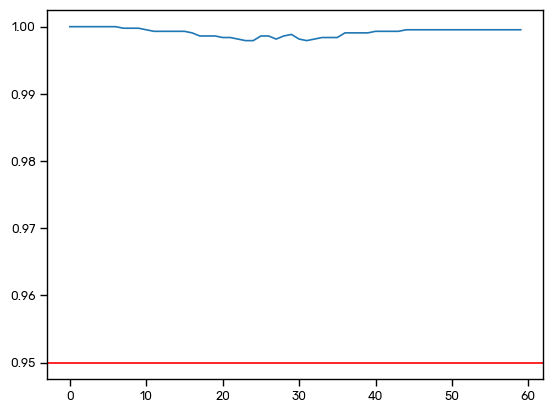

In [136]:
# Verify Quantiles - Single Step Coverage
rectangle_x_coverage = torch.logical_and(
    (rectangle_region['x_lower']<=rectangle_errors['test_x_errors']),
    (rectangle_errors['test_x_errors']<=rectangle_region['x_upper'])
)
rectangle_x_coverage = torch.hstack([torch.sum(rectangle_x_coverage[:,i])/rectangle_x_coverage[:,i].numel() for i in range(rectangle_x_coverage.shape[1])])
#rectangle_x_coverage = rectangle_x_coverage.sum()/rectangle_x_coverage.numel()
plt.plot(rectangle_x_coverage)
plt.axhline(1-delta, color='red')
print(rectangle_x_coverage.mean())

In [137]:
# Verify Quantiles - Multi-Step Coverage
rectangle_x_coverage = torch.logical_and(
    (rectangle_region['x_lower']<=rectangle_errors['test_x_errors']),
    (rectangle_errors['test_x_errors']<=rectangle_region['x_upper'])
)
rectangle_x_coverage = torch.hstack([torch.all(rectangle_x_coverage[i]) for i in range(rectangle_x_coverage.shape[0])])
rectangle_x_coverage = rectangle_x_coverage.sum()/rectangle_x_coverage.numel()
rectangle_x_coverage

tensor(0.9975)

tensor(0.9997)


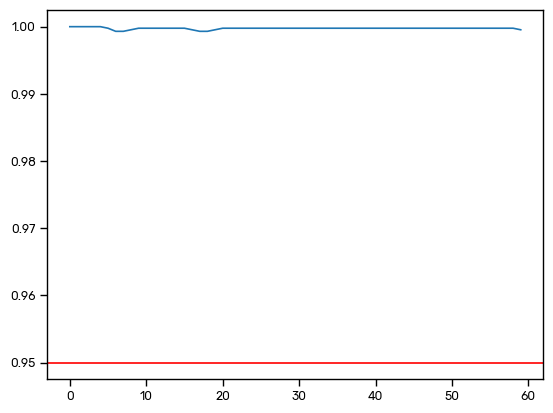

In [138]:
# Verify Quantiles - Single Step Coverage
rectangle_y_coverage = torch.logical_and(
    (rectangle_region['y_lower']<=rectangle_errors['test_y_errors']),
    (rectangle_errors['test_y_errors']<=rectangle_region['y_upper'])
)
rectangle_y_coverage = torch.hstack([torch.sum(rectangle_y_coverage[:,i])/rectangle_y_coverage[:,i].numel() for i in range(rectangle_y_coverage.shape[1])])
#rectangle_x_coverage = rectangle_x_coverage.sum()/rectangle_x_coverage.numel()
plt.plot(rectangle_y_coverage)
plt.axhline(1-delta, color='red')
print(rectangle_y_coverage.mean())

In [139]:
# Verify Quantiles - Multi-Step Coverage
rectangle_y_coverage = torch.logical_and(
    (rectangle_region['y_lower']<=rectangle_errors['test_y_errors']),
    (rectangle_errors['test_y_errors']<=rectangle_region['y_upper'])
)
rectangle_y_coverage = torch.hstack([torch.all(rectangle_y_coverage[i]) for i in range(rectangle_y_coverage.shape[0])])
rectangle_y_coverage = rectangle_y_coverage.sum()/rectangle_y_coverage.numel()
rectangle_y_coverage

tensor(0.9988)

### Rotated Rectangle

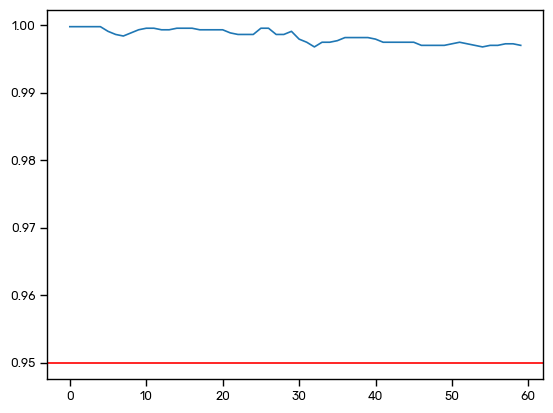

In [140]:
# Verify Quantiles - Single Step Coverage
rotated_rectangle_dual_coverage = torch.logical_and(
    torch.logical_and(
        (rotated_rectangle_region['x_lower']<=rotated_rectangle_errors['test_x_errors']),
        (rotated_rectangle_errors['test_x_errors']<=rotated_rectangle_region['x_upper'])
    ),
    torch.logical_and(
        (rotated_rectangle_region['y_lower']<=rotated_rectangle_errors['test_y_errors']),
        (rotated_rectangle_errors['test_y_errors']<=rotated_rectangle_region['y_upper'])
    ),
)
rotated_rectangle_dual_coverage = torch.hstack([torch.sum(rotated_rectangle_dual_coverage[:,i])/rotated_rectangle_dual_coverage[:,i].numel() for i in range(rotated_rectangle_dual_coverage.shape[1])])
#rotated_rectangle_dual_coverage = rotated_rectangle_dual_coverage.sum()/rotated_rectangle_dual_coverage.numel()
plt.plot(rotated_rectangle_dual_coverage)
plt.axhline(1-delta, color='red')

In [141]:
# Verify Quantiles - Multi-Step Coverage
rotated_rectangle_dual_coverage = torch.logical_and(
    torch.logical_and(
        (rotated_rectangle_region['x_lower']<=rotated_rectangle_errors['test_x_errors']),
        (rotated_rectangle_errors['test_x_errors']<=rotated_rectangle_region['x_upper'])
    ),
    torch.logical_and(
        (rotated_rectangle_region['y_lower']<=rotated_rectangle_errors['test_y_errors']),
        (rotated_rectangle_errors['test_y_errors']<=rotated_rectangle_region['y_upper'])
    ),
)
rotated_rectangle_dual_coverage = torch.hstack([torch.all(rotated_rectangle_dual_coverage[i]) for i in range(rotated_rectangle_dual_coverage.shape[0])])
rotated_rectangle_dual_coverage = rotated_rectangle_dual_coverage.sum()/rotated_rectangle_dual_coverage.numel()
rotated_rectangle_dual_coverage

tensor(0.9938)

tensor(0.9987)


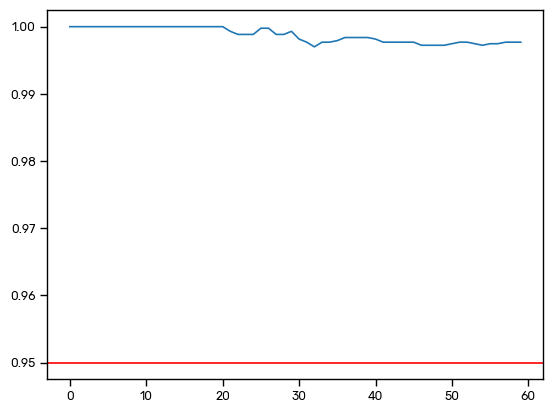

In [142]:
# Verify Quantiles - Single Step Coverage
rotated_rectangle_x_coverage = torch.logical_and(
    (rotated_rectangle_region['x_lower']<=rotated_rectangle_errors['test_x_errors']),
    (rotated_rectangle_errors['test_x_errors']<=rotated_rectangle_region['x_upper'])
)
rotated_rectangle_x_coverage = torch.hstack([torch.sum(rotated_rectangle_x_coverage[:,i])/rotated_rectangle_x_coverage[:,i].numel() for i in range(rotated_rectangle_x_coverage.shape[1])])
#rotated_rectangle_x_coverage = rotated_rectangle_x_coverage.sum()/rotated_rectangle_x_coverage.numel()
plt.plot(rotated_rectangle_x_coverage)
plt.axhline(1-delta, color='red')
print(rotated_rectangle_x_coverage.mean())

In [143]:
# Verify Quantiles - Multi-Step Coverage
rotated_rectangle_x_coverage = torch.logical_and(
    (rotated_rectangle_region['x_lower']<=rotated_rectangle_errors['test_x_errors']),
    (rotated_rectangle_errors['test_x_errors']<=rotated_rectangle_region['x_upper'])
)
rotated_rectangle_x_coverage = torch.hstack([torch.all(rotated_rectangle_x_coverage[i]) for i in range(rotated_rectangle_x_coverage.shape[0])])
rotated_rectangle_x_coverage = rotated_rectangle_x_coverage.sum()/rotated_rectangle_x_coverage.numel()
rotated_rectangle_x_coverage

tensor(0.9956)

tensor(0.9996)


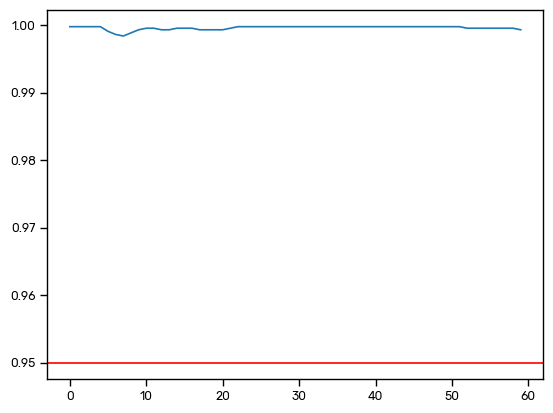

In [144]:
# Verify Quantiles - Single Step Coverage
rotated_rectangle_y_coverage = torch.logical_and(
    (rotated_rectangle_region['y_lower']<=rotated_rectangle_errors['test_y_errors']),
    (rotated_rectangle_errors['test_y_errors']<=rotated_rectangle_region['y_upper'])
)
rotated_rectangle_y_coverage = torch.hstack([torch.sum(rotated_rectangle_y_coverage[:,i])/rotated_rectangle_y_coverage[:,i].numel() for i in range(rotated_rectangle_y_coverage.shape[1])])
#rotated_rectangle_x_coverage = rotated_rectangle_x_coverage.sum()/rotated_rectangle_x_coverage.numel()
plt.plot(rotated_rectangle_y_coverage)
plt.axhline(1-delta, color='red')
print(rotated_rectangle_y_coverage.mean())

In [145]:
# Verify Quantiles - Multi-Step Coverage
rotated_rectangle_y_coverage = torch.logical_and(
    (rotated_rectangle_region['y_lower']<=rotated_rectangle_errors['test_y_errors']),
    (rotated_rectangle_errors['test_y_errors']<=rotated_rectangle_region['y_upper'])
)
rotated_rectangle_y_coverage = torch.hstack([torch.all(rotated_rectangle_y_coverage[i]) for i in range(rotated_rectangle_y_coverage.shape[0])])
rotated_rectangle_y_coverage = rotated_rectangle_y_coverage.sum()/rotated_rectangle_y_coverage.numel()
rotated_rectangle_y_coverage

tensor(0.9975)

### Frenet

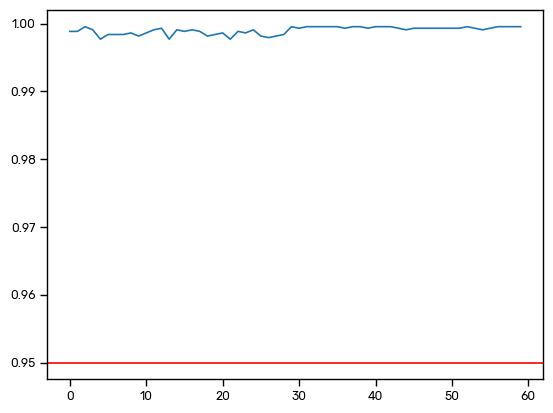

In [146]:
# Verify Quantiles - Single Step Coverage
frenet_dual_coverage = torch.logical_and(
    torch.logical_and(
        (frenet_region['prog_lower']<=frenet_errors['test_prog_errors']),
        (frenet_errors['test_prog_errors']<=frenet_region['prog_upper'])
    ),
    torch.logical_and(
        (frenet_region['disp_lower']<=frenet_errors['test_disp_errors']),
        (frenet_errors['test_disp_errors']<=frenet_region['disp_upper'])
    ),
)
frenet_dual_coverage = torch.hstack([torch.sum(frenet_dual_coverage[:,i])/frenet_dual_coverage[:,i].numel() for i in range(frenet_dual_coverage.shape[1])])
#frenet_dual_coverage = frenet_dual_coverage.sum()/frenet_dual_coverage.numel()
plt.plot(frenet_dual_coverage)
plt.axhline(1-delta, color='red')

In [147]:
# Verify Quantiles - Multi-Step Coverage
frenet_dual_coverage = torch.logical_and(
    torch.logical_and(
        (frenet_region['prog_lower']<=frenet_errors['test_prog_errors']),
        (frenet_errors['test_prog_errors']<=frenet_region['prog_upper'])
    ),
    torch.logical_and(
        (frenet_region['disp_lower']<=frenet_errors['test_disp_errors']),
        (frenet_errors['test_disp_errors']<=frenet_region['disp_upper'])
    ),
)
frenet_dual_coverage = torch.hstack([torch.all(frenet_dual_coverage[i]) for i in range(frenet_dual_coverage.shape[0])])
frenet_dual_coverage = frenet_dual_coverage.sum()/frenet_dual_coverage.numel()
frenet_dual_coverage

tensor(0.9843)

tensor(0.9992)


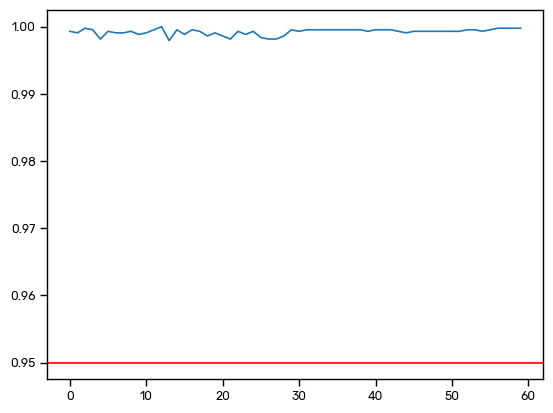

In [148]:
# Verify Quantiles - Single Step Coverage
frenet_prog_coverage = torch.logical_and(
    (frenet_region['prog_lower']<=frenet_errors['test_prog_errors']),
    (frenet_errors['test_prog_errors']<=frenet_region['prog_upper'])
)
frenet_prog_coverage = torch.hstack([torch.sum(frenet_prog_coverage[:,i])/frenet_prog_coverage[:,i].numel() for i in range(frenet_prog_coverage.shape[1])])
#frenet_prog_coverage = frenet_prog_coverage.sum()/frenet_prog_coverage.numel()
plt.plot(frenet_prog_coverage)
plt.axhline(1-delta, color='red')
print(frenet_prog_coverage.mean())

In [149]:
# Verify Quantiles - Multi-Step Coverage
frenet_prog_coverage = torch.logical_and(
    (frenet_region['prog_lower']<=frenet_errors['test_prog_errors']),
    (frenet_errors['test_prog_errors']<=frenet_region['prog_upper'])
)
frenet_prog_coverage = torch.hstack([torch.all(frenet_prog_coverage[i]) for i in range(frenet_prog_coverage.shape[0])])
frenet_prog_coverage = frenet_prog_coverage.sum()/frenet_prog_coverage.numel()
frenet_prog_coverage

tensor(0.9864)

tensor(0.9996)


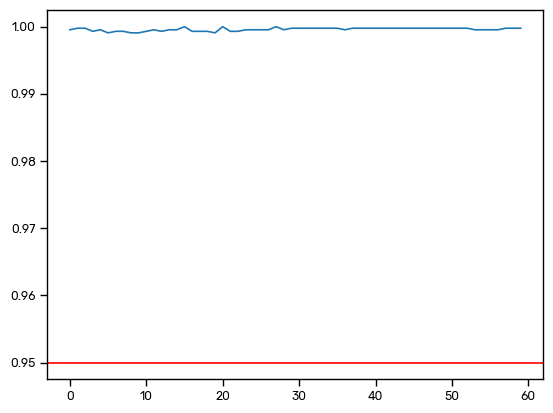

In [150]:
# Verify Quantiles - Single Step Coverage
frenet_disp_coverage = torch.logical_and(
    (frenet_region['disp_lower']<=frenet_errors['test_disp_errors']),
    (frenet_errors['test_disp_errors']<=frenet_region['disp_upper'])
)
frenet_disp_coverage = torch.hstack([torch.sum(frenet_disp_coverage[:,i])/frenet_disp_coverage[:,i].numel() for i in range(frenet_disp_coverage.shape[1])])
#frenet_disp_coverage = frenet_disp_coverage.sum()/frenet_disp_coverage.numel()
plt.plot(frenet_disp_coverage)
plt.axhline(1-delta, color='red')
print(frenet_disp_coverage.mean())

In [151]:
# Verify Quantiles - Multi-Step Coverage
frenet_disp_coverage = torch.logical_and(
    (frenet_region['disp_lower']<=frenet_errors['test_disp_errors']),
    (frenet_errors['test_disp_errors']<=frenet_region['disp_upper'])
)
frenet_disp_coverage = torch.hstack([torch.all(frenet_disp_coverage[i]) for i in range(frenet_disp_coverage.shape[0])])
frenet_disp_coverage = frenet_disp_coverage.sum()/frenet_disp_coverage.numel()
frenet_disp_coverage

tensor(0.9961)

## Displacement Error

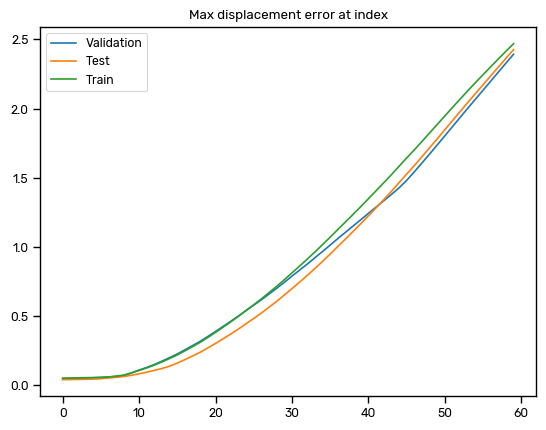

In [47]:
v_values, indices = val_errors['disp_errors'].max(dim=0)
t_values, indices = test_errors['disp_errors'].max(dim=0)
tr_values, indices = train_errors['disp_errors'].max(dim=0)
plt.plot(v_values, label="Validation")
plt.plot(t_values, label="Test")
plt.plot(tr_values, label="Train")
plt.legend()
plt.title("Max displacement error at index");

In [48]:
val_disp_quantiles = {
    'q_97': val_errors['disp_errors'].quantile(0.97, dim=0),
    'q_95': val_errors['disp_errors'].quantile(0.95, dim=0),
    'q_90': val_errors['disp_errors'].quantile(0.9, dim=0),
}
test_disp_quantiles = {
    'q_97': test_errors['disp_errors'].quantile(0.97, dim=0),
    'q_95': test_errors['disp_errors'].quantile(0.95, dim=0),
    'q_90': test_errors['disp_errors'].quantile(0.9, dim=0),
}

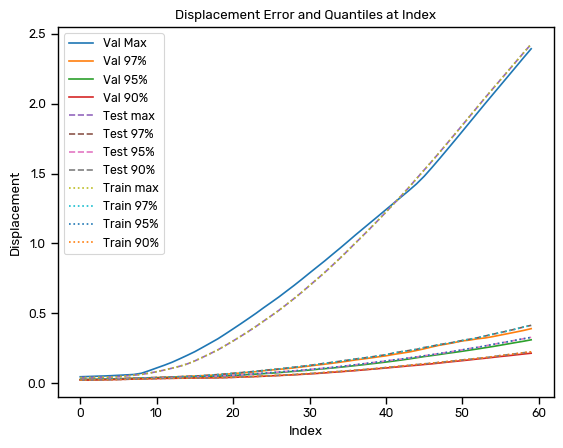

In [49]:
plt.plot(v_values, label="Val Max")
plt.plot(val_disp_quantiles['q_97'], label="Val 97%")
plt.plot(val_disp_quantiles['q_95'], label="Val 95%")
plt.plot(val_disp_quantiles['q_90'], label="Val 90%")
plt.plot(t_values, label="Test max", linestyle='dashed')
plt.plot(test_disp_quantiles['q_97'], label="Test 97%", linestyle='dashed')
plt.plot(test_disp_quantiles['q_95'], label="Test 95%", linestyle='dashed')
plt.plot(test_disp_quantiles['q_90'], label="Test 90%", linestyle='dashed')
plt.plot(t_values, label="Train max", linestyle='dotted')
plt.plot(test_disp_quantiles['q_97'], label="Train 97%", linestyle='dotted')
plt.plot(test_disp_quantiles['q_95'], label="Train 95%", linestyle='dotted')
plt.plot(test_disp_quantiles['q_90'], label="Train 90%", linestyle='dotted')
plt.xlabel("Index")
plt.ylabel("Displacement")
plt.title("Displacement Error and Quantiles at Index")
plt.legend()

## X-Y Axis Error

In [50]:
val_x_errors = val_errors['dim_disp_errors'][..., 0]
val_y_errors = val_errors['dim_disp_errors'][..., 1]
test_x_errors = test_errors['dim_disp_errors'][..., 0]
test_y_errors = test_errors['dim_disp_errors'][..., 1]

Text(0.5, 1.0, 'X error at index')

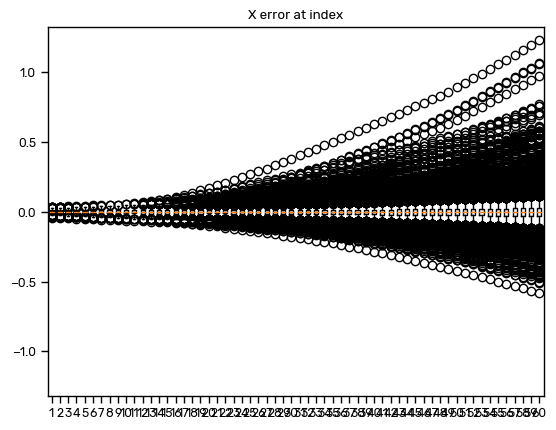

In [51]:
plt.boxplot(val_x_errors.T)
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.title("X error at index")

Text(0.5, 1.0, 'Y error at index')

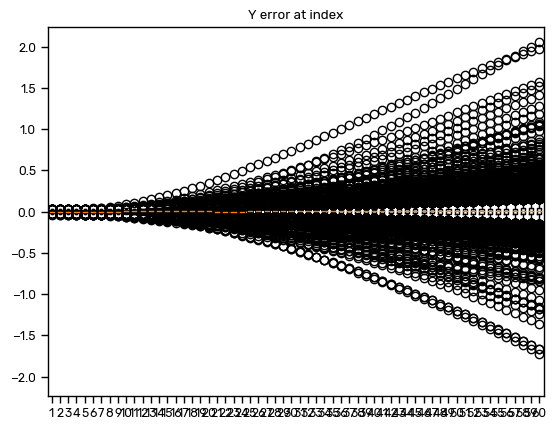

In [52]:
plt.boxplot(val_y_errors.T)
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.title("Y error at index")

In [53]:
val_box_errors = {
    'x_min': val_x_errors.quantile(0, dim=0),
    'x_max': val_x_errors.quantile(1, dim=0),
    'xlower_95': val_x_errors.quantile(0.025, dim=0),
    'xupper_95': val_x_errors.quantile(0.975, dim=0),
    'xlower_90': val_x_errors.quantile(0.05, dim=0),
    'xupper_90': val_x_errors.quantile(0.95, dim=0),
    'y_min': val_y_errors.quantile(0, dim=0),
    'y_max': val_y_errors.quantile(1, dim=0),
    'ylower_95': val_y_errors.quantile(0.025, dim=0),
    'yupper_95': val_y_errors.quantile(0.975, dim=0),
    'ylower_90': val_y_errors.quantile(0.05, dim=0),
    'yupper_90': val_y_errors.quantile(0.95, dim=0),
}
test_box_errors = {
    'x_min': test_x_errors.quantile(0, dim=0),
    'x_max': test_x_errors.quantile(1, dim=0),
    'xlower_95': test_x_errors.quantile(0.025, dim=0),
    'xupper_95': test_x_errors.quantile(0.975, dim=0),
    'xlower_90': test_x_errors.quantile(0.05, dim=0),
    'xupper_90': test_x_errors.quantile(0.95, dim=0),
    'y_min': test_y_errors.quantile(0, dim=0),
    'y_max': test_y_errors.quantile(1, dim=0),
    'ylower_95': test_y_errors.quantile(0.025, dim=0),
    'yupper_95': test_y_errors.quantile(0.975, dim=0),
    'ylower_90': test_y_errors.quantile(0.05, dim=0),
    'yupper_90': test_y_errors.quantile(0.95, dim=0),
}

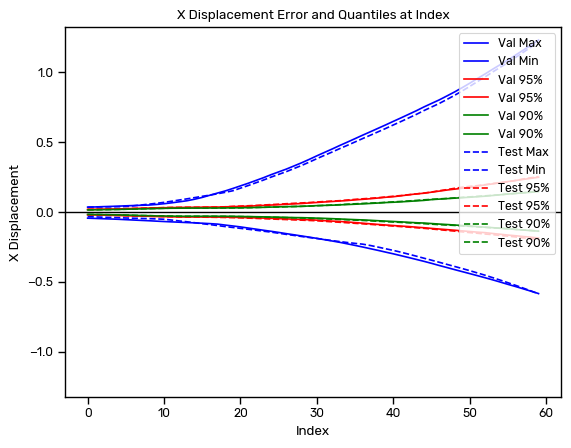

In [54]:
plt.plot(val_box_errors['x_min'], label="Val Max", color='blue')
plt.plot(val_box_errors['x_max'], label="Val Min", color='blue')
plt.plot(val_box_errors['xlower_95'], label="Val 95%", color='red')
plt.plot(val_box_errors['xupper_95'], label="Val 95%", color='red')
plt.plot(val_box_errors['xlower_90'], label="Val 90%", color='green')
plt.plot(val_box_errors['xupper_90'], label="Val 90%", color='green')
plt.plot(test_box_errors['x_min'], label="Test Max", color='blue', linestyle='dashed')
plt.plot(test_box_errors['x_max'], label="Test Min", color='blue', linestyle='dashed')
plt.plot(test_box_errors['xlower_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_box_errors['xupper_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_box_errors['xlower_90'], label="Test 90%", color='green', linestyle='dashed')
plt.plot(test_box_errors['xupper_90'], label="Test 90%", color='green', linestyle='dashed')
plt.axhline(0, linewidth=1, color='black')
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.xlabel("Index")
plt.ylabel("X Displacement")
plt.title("X Displacement Error and Quantiles at Index")
plt.legend()

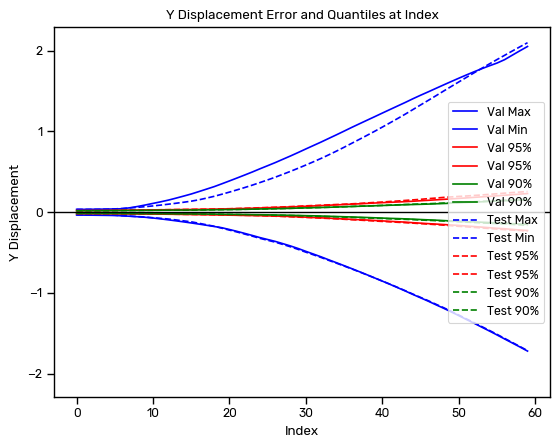

In [55]:
plt.plot(val_box_errors['y_min'], label="Val Max", color='blue')
plt.plot(val_box_errors['y_max'], label="Val Min", color='blue')
plt.plot(val_box_errors['ylower_95'], label="Val 95%", color='red')
plt.plot(val_box_errors['yupper_95'], label="Val 95%", color='red')
plt.plot(val_box_errors['ylower_90'], label="Val 90%", color='green')
plt.plot(val_box_errors['yupper_90'], label="Val 90%", color='green')
plt.plot(test_box_errors['y_min'], label="Test Max", color='blue', linestyle='dashed')
plt.plot(test_box_errors['y_max'], label="Test Min", color='blue', linestyle='dashed')
plt.plot(test_box_errors['ylower_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_box_errors['yupper_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_box_errors['ylower_90'], label="Test 90%", color='green', linestyle='dashed')
plt.plot(test_box_errors['yupper_90'], label="Test 90%", color='green', linestyle='dashed')
plt.axhline(0, linewidth=1, color='black')
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.xlabel("Index")
plt.ylabel("Y Displacement")
plt.title("Y Displacement Error and Quantiles at Index")
plt.legend()

## Rotated X-Y Displacement Error

In [56]:
val_rot_x_errors = val_errors['rotated_dim_disp_errors'][..., 0]
val_rot_y_errors = val_errors['rotated_dim_disp_errors'][..., 1]
test_rot_x_errors = test_errors['rotated_dim_disp_errors'][..., 0]
test_rot_y_errors = test_errors['rotated_dim_disp_errors'][..., 1]

Text(0.5, 1.0, 'Rotated X error at index')

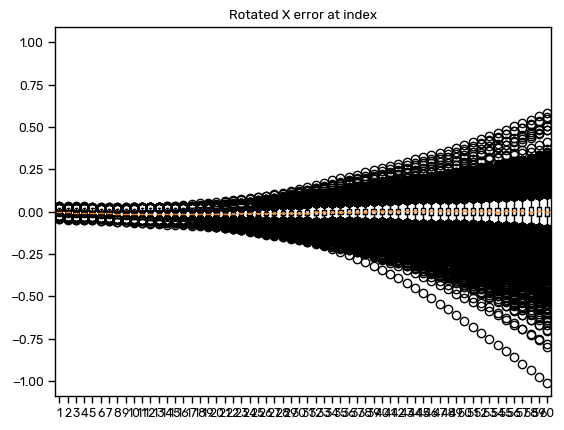

In [57]:
plt.boxplot(val_rot_x_errors.T)
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.title("Rotated X error at index")

Text(0.5, 1.0, 'Rotated Y error at index')

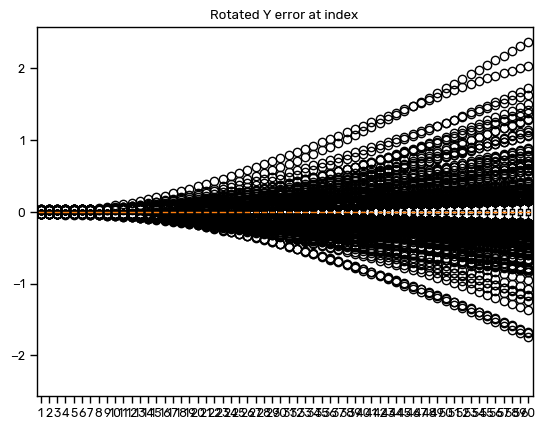

In [58]:
plt.boxplot(val_rot_y_errors.T)
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.title("Rotated Y error at index")

In [59]:
val_rot_box_errors = {
    'x_min': val_rot_x_errors.quantile(0, dim=0),
    'x_max': val_rot_x_errors.quantile(1, dim=0),
    'xlower_95': val_rot_x_errors.quantile(0.025, dim=0),
    'xupper_95': val_rot_x_errors.quantile(0.975, dim=0),
    'xlower_90': val_rot_x_errors.quantile(0.05, dim=0),
    'xupper_90': val_rot_x_errors.quantile(0.95, dim=0),
    'y_min': val_rot_y_errors.quantile(0, dim=0),
    'y_max': val_rot_y_errors.quantile(1, dim=0),
    'ylower_95': val_rot_y_errors.quantile(0.025, dim=0),
    'yupper_95': val_rot_y_errors.quantile(0.975, dim=0),
    'ylower_90': val_rot_y_errors.quantile(0.05, dim=0),
    'yupper_90': val_rot_y_errors.quantile(0.95, dim=0),
}
test_rot_box_errors = {
    'x_min': test_rot_x_errors.quantile(0, dim=0),
    'x_max': test_rot_x_errors.quantile(1, dim=0),
    'xlower_95': test_rot_x_errors.quantile(0.025, dim=0),
    'xupper_95': test_rot_x_errors.quantile(0.975, dim=0),
    'xlower_90': test_rot_x_errors.quantile(0.05, dim=0),
    'xupper_90': test_rot_x_errors.quantile(0.95, dim=0),
    'y_min': test_rot_y_errors.quantile(0, dim=0),
    'y_max': test_rot_y_errors.quantile(1, dim=0),
    'ylower_95': test_rot_y_errors.quantile(0.025, dim=0),
    'yupper_95': test_rot_y_errors.quantile(0.975, dim=0),
    'ylower_90': test_rot_y_errors.quantile(0.05, dim=0),
    'yupper_90': test_rot_y_errors.quantile(0.95, dim=0),
}

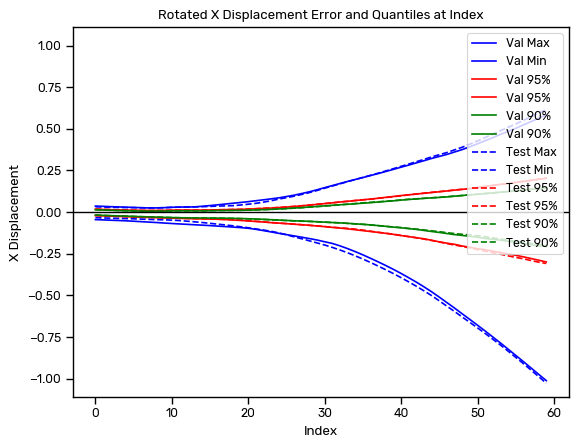

In [60]:
plt.plot(val_rot_box_errors['x_min'], label="Val Max", color='blue')
plt.plot(val_rot_box_errors['x_max'], label="Val Min", color='blue')
plt.plot(val_rot_box_errors['xlower_95'], label="Val 95%", color='red')
plt.plot(val_rot_box_errors['xupper_95'], label="Val 95%", color='red')
plt.plot(val_rot_box_errors['xlower_90'], label="Val 90%", color='green')
plt.plot(val_rot_box_errors['xupper_90'], label="Val 90%", color='green')
plt.plot(test_rot_box_errors['x_min'], label="Test Max", color='blue', linestyle='dashed')
plt.plot(test_rot_box_errors['x_max'], label="Test Min", color='blue', linestyle='dashed')
plt.plot(test_rot_box_errors['xlower_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_rot_box_errors['xupper_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_rot_box_errors['xlower_90'], label="Test 90%", color='green', linestyle='dashed')
plt.plot(test_rot_box_errors['xupper_90'], label="Test 90%", color='green', linestyle='dashed')
plt.axhline(0, linewidth=1, color='black')
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.xlabel("Index")
plt.ylabel("X Displacement")
plt.title("Rotated X Displacement Error and Quantiles at Index")
plt.legend()

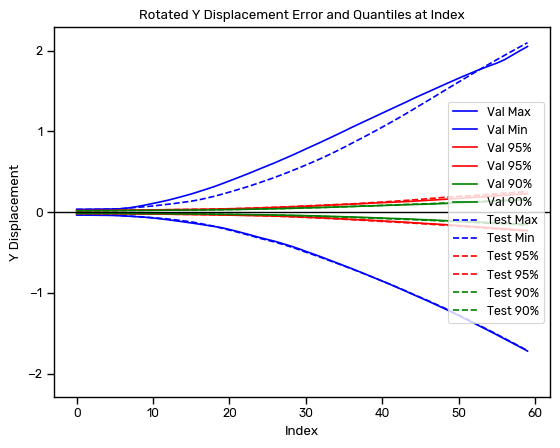

In [61]:
plt.plot(val_box_errors['y_min'], label="Val Max", color='blue')
plt.plot(val_box_errors['y_max'], label="Val Min", color='blue')
plt.plot(val_box_errors['ylower_95'], label="Val 95%", color='red')
plt.plot(val_box_errors['yupper_95'], label="Val 95%", color='red')
plt.plot(val_box_errors['ylower_90'], label="Val 90%", color='green')
plt.plot(val_box_errors['yupper_90'], label="Val 90%", color='green')
plt.plot(test_box_errors['y_min'], label="Test Max", color='blue', linestyle='dashed')
plt.plot(test_box_errors['y_max'], label="Test Min", color='blue', linestyle='dashed')
plt.plot(test_box_errors['ylower_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_box_errors['yupper_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_box_errors['ylower_90'], label="Test 90%", color='green', linestyle='dashed')
plt.plot(test_box_errors['yupper_90'], label="Test 90%", color='green', linestyle='dashed')
plt.axhline(0, linewidth=1, color='black')
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.xlabel("Index")
plt.ylabel("Y Displacement")
plt.title("Rotated Y Displacement Error and Quantiles at Index")
plt.legend()

## Frenet Frame Errors

In [62]:
val_fre_prog_errors = val_errors['frenet_disp_errors'][..., 0]
val_fre_disp_errors = val_errors['frenet_disp_errors'][..., 1]
test_fre_prog_errors = test_errors['frenet_disp_errors'][..., 0]
test_fre_disp_errors = test_errors['frenet_disp_errors'][..., 1]
train_fre_prog_errors = train_errors['frenet_disp_errors'][..., 0]
train_fre_disp_errors = train_errors['frenet_disp_errors'][..., 1]

Text(0.5, 1.0, 'Frenet Progress error at index')

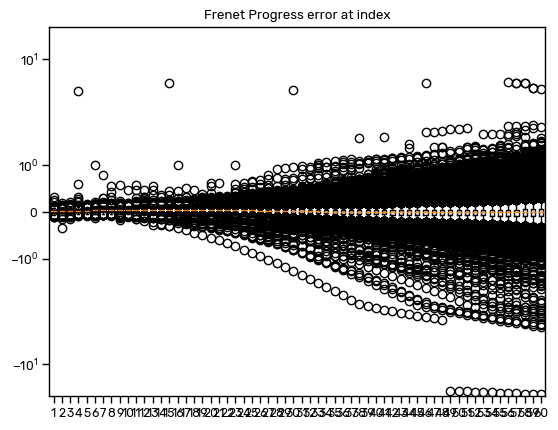

In [63]:
plt.boxplot(val_fre_prog_errors.T)
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.yscale('symlog')
plt.axhline(500, color='red')
plt.axhline(-500, color='red')
plt.title("Frenet Progress error at index")

Text(0.5, 1.0, 'Frenet Displacement error at index')

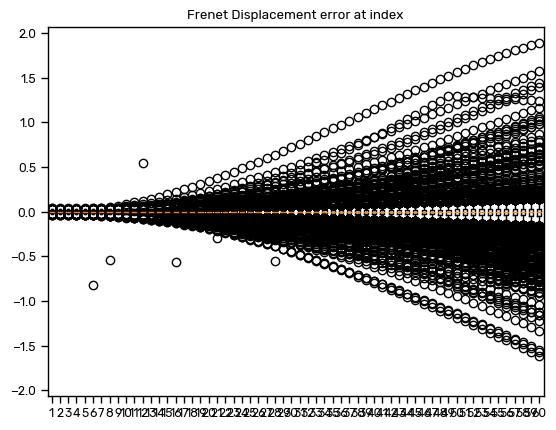

In [64]:
plt.boxplot(val_fre_disp_errors.T)
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.title("Frenet Displacement error at index")

In [65]:
val_frenet_quantiles = {
    'fre_prog_min': val_fre_prog_errors.quantile(0, dim=0),
    'fre_prog_max': val_fre_prog_errors.quantile(1, dim=0),
    'fre_proglower_95': val_fre_prog_errors.quantile(0.025, dim=0),
    'fre_progupper_95': val_fre_prog_errors.quantile(0.975, dim=0),
    'fre_proglower_90': val_fre_prog_errors.quantile(0.05, dim=0),
    'fre_progupper_90': val_fre_prog_errors.quantile(0.95, dim=0),
    'fre_disp_min': val_fre_disp_errors.quantile(0, dim=0),
    'fre_disp_max': val_fre_disp_errors.quantile(1, dim=0),
    'fre_displower_95': val_fre_disp_errors.quantile(0.025, dim=0),
    'fre_dispupper_95': val_fre_disp_errors.quantile(0.975, dim=0),
    'fre_displower_90': val_fre_disp_errors.quantile(0.05, dim=0),
    'fre_dispupper_90': val_fre_disp_errors.quantile(0.95, dim=0),
}
test_frenet_quantiles = {
    'fre_prog_min': test_fre_prog_errors.quantile(0, dim=0),
    'fre_prog_max': test_fre_prog_errors.quantile(1, dim=0),
    'fre_proglower_95': test_fre_prog_errors.quantile(0.025, dim=0),
    'fre_progupper_95': test_fre_prog_errors.quantile(0.975, dim=0),
    'fre_proglower_90': test_fre_prog_errors.quantile(0.05, dim=0),
    'fre_progupper_90': test_fre_prog_errors.quantile(0.95, dim=0),
    'fre_disp_min': test_fre_disp_errors.quantile(0, dim=0),
    'fre_disp_max': test_fre_disp_errors.quantile(1, dim=0),
    'fre_displower_95': test_fre_disp_errors.quantile(0.025, dim=0),
    'fre_dispupper_95': test_fre_disp_errors.quantile(0.975, dim=0),
    'fre_displower_90': test_fre_disp_errors.quantile(0.05, dim=0),
    'fre_dispupper_90': test_fre_disp_errors.quantile(0.95, dim=0),
}
train_frenet_quantiles = {
    'fre_prog_min': train_fre_prog_errors.quantile(0, dim=0),
    'fre_prog_max': train_fre_prog_errors.quantile(1, dim=0),
    'fre_proglower_95': train_fre_prog_errors.quantile(0.025, dim=0),
    'fre_progupper_95': train_fre_prog_errors.quantile(0.975, dim=0),
    'fre_proglower_90': train_fre_prog_errors.quantile(0.05, dim=0),
    'fre_progupper_90': train_fre_prog_errors.quantile(0.95, dim=0),
    'fre_disp_min': train_fre_disp_errors.quantile(0, dim=0),
    'fre_disp_max': train_fre_disp_errors.quantile(1, dim=0),
    'fre_displower_95': train_fre_disp_errors.quantile(0.025, dim=0),
    'fre_dispupper_95': train_fre_disp_errors.quantile(0.975, dim=0),
    'fre_displower_90': train_fre_disp_errors.quantile(0.05, dim=0),
    'fre_dispupper_90': train_fre_disp_errors.quantile(0.95, dim=0),
}

In [66]:
train_frenet_quantiles['fre_displower_95']

tensor([-0.0198, -0.0198, -0.0201, -0.0204, -0.0209, -0.0216, -0.0226, -0.0234,
        -0.0247, -0.0261, -0.0278, -0.0293, -0.0313, -0.0334, -0.0357, -0.0378,
        -0.0396, -0.0420, -0.0447, -0.0475, -0.0502, -0.0533, -0.0561, -0.0598,
        -0.0622, -0.0661, -0.0705, -0.0744, -0.0788, -0.0826, -0.0869, -0.0911,
        -0.0955, -0.0998, -0.1044, -0.1097, -0.1147, -0.1209, -0.1260, -0.1326,
        -0.1380, -0.1452, -0.1513, -0.1583, -0.1651, -0.1743, -0.1819, -0.1909,
        -0.1981, -0.2054, -0.2137, -0.2215, -0.2291, -0.2384, -0.2480, -0.2580,
        -0.2680, -0.2781, -0.2887, -0.2999], dtype=torch.float64)

In [67]:
train_frenet_quantiles['fre_dispupper_95']

tensor([0.0196, 0.0196, 0.0198, 0.0201, 0.0202, 0.0205, 0.0208, 0.0214, 0.0219,
        0.0225, 0.0232, 0.0240, 0.0248, 0.0257, 0.0265, 0.0276, 0.0287, 0.0299,
        0.0311, 0.0324, 0.0344, 0.0360, 0.0377, 0.0392, 0.0415, 0.0434, 0.0451,
        0.0473, 0.0490, 0.0510, 0.0538, 0.0566, 0.0588, 0.0613, 0.0637, 0.0663,
        0.0692, 0.0715, 0.0742, 0.0769, 0.0799, 0.0829, 0.0860, 0.0891, 0.0924,
        0.0950, 0.0980, 0.1009, 0.1045, 0.1083, 0.1113, 0.1152, 0.1190, 0.1224,
        0.1253, 0.1281, 0.1316, 0.1348, 0.1384, 0.1419], dtype=torch.float64)

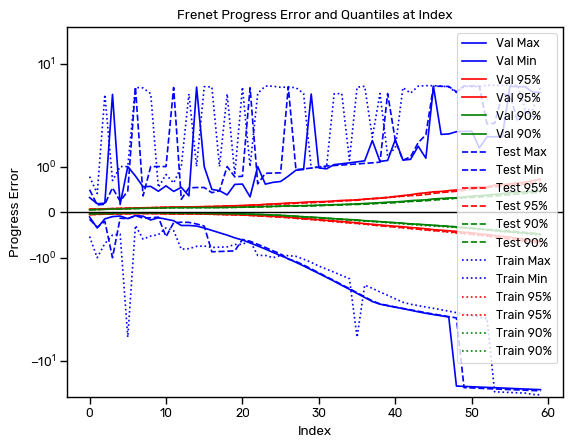

In [68]:
with plt.ion():
    plt.plot(val_frenet_quantiles['fre_prog_max'], label="Val Max", color='blue')
    plt.plot(val_frenet_quantiles['fre_prog_min'], label="Val Min", color='blue')
    plt.plot(val_frenet_quantiles['fre_proglower_95'], label="Val 95%", color='red')
    plt.plot(val_frenet_quantiles['fre_progupper_95'], label="Val 95%", color='red')
    plt.plot(val_frenet_quantiles['fre_proglower_90'], label="Val 90%", color='green')
    plt.plot(val_frenet_quantiles['fre_progupper_90'], label="Val 90%", color='green')
    plt.plot(test_frenet_quantiles['fre_prog_max'], label="Test Max", color='blue', linestyle='dashed')
    plt.plot(test_frenet_quantiles['fre_prog_min'], label="Test Min", color='blue', linestyle='dashed')
    plt.plot(test_frenet_quantiles['fre_proglower_95'], label="Test 95%", color='red', linestyle='dashed')
    plt.plot(test_frenet_quantiles['fre_progupper_95'], label="Test 95%", color='red', linestyle='dashed')
    plt.plot(test_frenet_quantiles['fre_proglower_90'], label="Test 90%", color='green', linestyle='dashed')
    plt.plot(test_frenet_quantiles['fre_progupper_90'], label="Test 90%", color='green', linestyle='dashed')
    plt.plot(train_frenet_quantiles['fre_prog_max'], label="Train Max", color='blue', linestyle='dotted')
    plt.plot(train_frenet_quantiles['fre_prog_min'], label="Train Min", color='blue', linestyle='dotted')
    plt.plot(train_frenet_quantiles['fre_proglower_95'], label="Train 95%", color='red', linestyle='dotted')
    plt.plot(train_frenet_quantiles['fre_progupper_95'], label="Train 95%", color='red', linestyle='dotted')
    plt.plot(train_frenet_quantiles['fre_proglower_90'], label="Train 90%", color='green', linestyle='dotted')
    plt.plot(train_frenet_quantiles['fre_progupper_90'], label="Train 90%", color='green', linestyle='dotted')
    plt.axhline(0, linewidth=1, color='black')
    ylim = plt.gca().get_ylim()
    bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
    plt.ylim(-bound, bound)
    plt.xlabel("Index")
    plt.ylabel("Progress Error")
    plt.title("Frenet Progress Error and Quantiles at Index")
    plt.yscale('symlog')
    plt.legend()

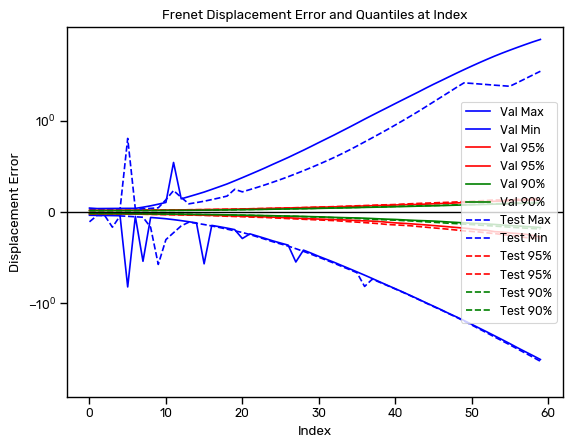

In [69]:
plt.plot(val_frenet_quantiles['fre_disp_max'], label="Val Max", color='blue')
plt.plot(val_frenet_quantiles['fre_disp_min'], label="Val Min", color='blue')
plt.plot(val_frenet_quantiles['fre_displower_95'], label="Val 95%", color='red')
plt.plot(val_frenet_quantiles['fre_dispupper_95'], label="Val 95%", color='red')
plt.plot(val_frenet_quantiles['fre_displower_90'], label="Val 90%", color='green')
plt.plot(val_frenet_quantiles['fre_dispupper_90'], label="Val 90%", color='green')
plt.plot(test_frenet_quantiles['fre_disp_max'], label="Test Max", color='blue', linestyle='dashed')
plt.plot(test_frenet_quantiles['fre_disp_min'], label="Test Min", color='blue', linestyle='dashed')
plt.plot(test_frenet_quantiles['fre_displower_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_frenet_quantiles['fre_dispupper_95'], label="Test 95%", color='red', linestyle='dashed')
plt.plot(test_frenet_quantiles['fre_displower_90'], label="Test 90%", color='green', linestyle='dashed')
plt.plot(test_frenet_quantiles['fre_dispupper_90'], label="Test 90%", color='green', linestyle='dashed')
plt.axhline(0, linewidth=1, color='black')
ylim = plt.gca().get_ylim()
bound = max(np.abs(ylim[0]), np.abs(ylim[1]))
plt.ylim(-bound, bound)
plt.xlabel("Index")
plt.ylabel("Displacement Error")
plt.title("Frenet Displacement Error and Quantiles at Index")
plt.yscale('symlog')
plt.legend()

## Plotting

In [70]:
def create_single_plot(input, target, prediction, ax=None, heading_boxes=True, buffer=0.5, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)
    else:
        fig = None
    assert(isinstance(input, np.ndarray))
    assert(isinstance(target, np.ndarray))
    assert(isinstance(prediction, np.ndarray))
    
    (linput,) = ax.plot(
        input[:, 0],
        input[:, 1],
        marker=".",
        label="Input",
    )
    (ltarget,) = ax.plot(
        target[:, 0],
        target[:, 1],
        marker=".",
        label="Truth",
    )
    (lpred,) = ax.plot(
        prediction[:, 0],
        prediction[:, 1],
        marker=".",
        label="Prediction",
    )

    if heading_boxes:
        center = (prediction[-1, 0], prediction[-1, 1])
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="green",
                fill=False,
                angle=rad_to_deg(prediction[-1, 2]),
                rotation_point=center,
            )
        )

        center = (target[-1, 0], target[-1, 1])
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="orange",
                fill=False,
                angle=rad_to_deg(target[-1, 2]),
                rotation_point=center,
            )
        )
        center = (prediction[-30, 0], prediction[-30, 1])
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="green",
                fill=False,
                angle=rad_to_deg(prediction[-30, 2]),
                rotation_point=center,
            )
        )
        center = (
            target[-30, 0],
            target[-30, 1],
        )
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="orange",
                fill=False,
                angle=rad_to_deg(target[-30, 2]),
                rotation_point=center,
            )
        )

        center = (
            input[-1, 0],
            input[-1, 1],
        )
        corner = [center[0] - (CAR_LENGTH / 2), center[1] - (CAR_WIDTH / 2)]
        ax.add_patch(
            plt.Rectangle(
                corner,
                CAR_LENGTH,
                CAR_WIDTH,
                edgecolor="blue",
                fill=False,
                angle=rad_to_deg(input[-1, 2]),
                rotation_point=center,
            )
        )

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    max_offset_x = max(np.mean(xlim) - xlim[0], xlim[1] - np.mean(xlim))
    max_offset_y = max(np.mean(ylim) - ylim[0], ylim[1] - np.mean(ylim))
    max_offset = max(max_offset_x, max_offset_y) + buffer
    ax.scatter(map_x, map_y, marker=".", color="black")
    ax.set(
        xlim=(np.mean(xlim) - max_offset, np.mean(xlim) + max_offset),
        ylim=(np.mean(ylim) - max_offset, np.mean(ylim) + max_offset),
        aspect=1.0,
        #adjustable="box",
        yticklabels=[],
        xticklabels=[],
    )
    ax.tick_params(          
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False
    )
    if fig is None:
        return ax
    else:
        return fig, ax

In [71]:
from vmp.data_utils import VAL_LIST
IDX = 21670#VAL_LIST[2]#43226
with torch.no_grad():
    input = torch.tensor(full_frame.loc[IDX]['input_vel'], device=DEVICE).unsqueeze(0)
    target = torch.tensor(full_frame.loc[IDX]['target'], device=DEVICE).unsqueeze(0)
    last_pose = torch.tensor(full_frame.loc[IDX]['last_pose'], device=DEVICE).unsqueeze(0)
    output, _ = net.predict(input, last_pose, control_input_bias=control_input_bias)
    lstm_output = lstm_net.predict(input, last_pose)

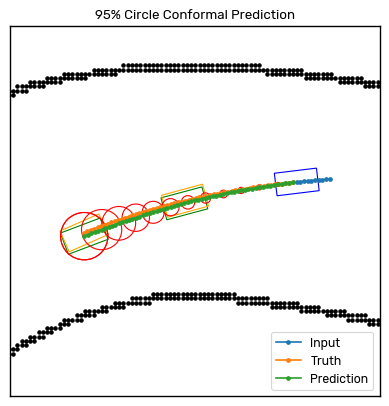

In [72]:
fig, ax = create_single_plot(input.squeeze(0).cpu().numpy(), target.squeeze(0).cpu().numpy(), output.squeeze(0).cpu().numpy())
circles = list()
for i in range(-1, output.squeeze(0).shape[0], 5):
    # for the tenth one, draw the tenth circle
    circles.append(plt.Circle((output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()), displacement_region['upper'][i], edgecolor='red', fill=False))
    #circles.append(plt.Circle((output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()), displacement_region['lower'][i], edgecolor='red', fill=False))
for circle in circles:
    ax.add_patch(circle)
ax.set_title("95% Circle Conformal Prediction")
ax.legend()

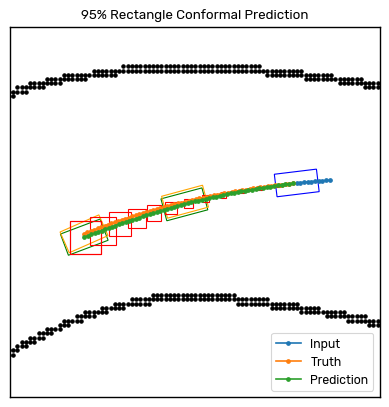

In [73]:
fig, ax = create_single_plot(input.squeeze(0).cpu().numpy(), target.squeeze(0).cpu().numpy(), output.squeeze(0).cpu().numpy())
boxes = list()
for i in range(-1, output.squeeze(0).shape[0], 5):
    # for the tenth one, draw the tenth circle
    originx, originy = output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()
    bounds = ((originx+rectangle_region['x_lower'][i], originx+rectangle_region['x_upper'][i]), (originy+rectangle_region['y_lower'][i], originy+rectangle_region['y_upper'][i]))
    width, height = (bounds[0][1]-bounds[0][0], bounds[1][1]-bounds[1][0])
    corner = (bounds[0][0], bounds[1][0])
    boxes.append(plt.Rectangle(corner, width, height, edgecolor='red', fill=False))
for box in boxes:
    ax.add_patch(box)
ax.set_title("95% Rectangle Conformal Prediction")
ax.legend()

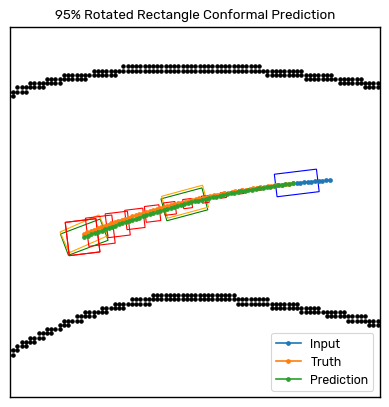

In [74]:
fig, ax = create_single_plot(input.squeeze(0).cpu().numpy(), target.squeeze(0).cpu().numpy(), output.squeeze(0).cpu().numpy())
rot_input, rot_target, rot_output = rotate_sample(input[0].cpu(), last_pose[0].cpu(), target[0].cpu(), output[0].cpu())
rot_output += last_pose[0, :2].cpu()
boxes = list()
for i in range(-1, output.squeeze(0).shape[0], 5):
    originx, originy = rot_output[i,0].item(), rot_output[i,1].item()
    angle = rad_to_deg(last_pose[0, 2].cpu().numpy())  # Angle
    rot_origin = tuple(last_pose[0, :2].cpu().numpy()) # Last Pose Origin
    width, height = (rotated_rectangle_region['x_upper'][i]-rotated_rectangle_region['x_lower'][i], rotated_rectangle_region['y_upper'][i]-rotated_rectangle_region['y_lower'][i])
    corner = (originx+rotated_rectangle_region['x_lower'][i], originy+rotated_rectangle_region['y_lower'][i])
    boxes.append(plt.Rectangle(corner, width, height, edgecolor='red', fill=False, angle=angle, rotation_point=rot_origin))
for box in boxes:
    ax.add_patch(box)
ax.set_title("95% Rotated Rectangle Conformal Prediction")
ax.legend()

  0%|          | 0/13 [00:00<?, ?it/s]

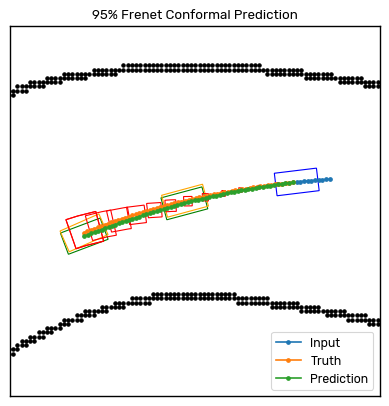

In [75]:
fig, ax = create_single_plot(input.squeeze(0).cpu().numpy(), target.squeeze(0).cpu().numpy(), output.squeeze(0).cpu().numpy())
polygons = list()
for i in tqdm(range(-1, output.squeeze(0).shape[0], 5)):
    originx, originy = output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()
    frenet_origin = point_to_frenet(output.squeeze(0)[i,:2].cpu().numpy(), centerline)
    frenet_prog_range = np.arange(frenet_region['prog_lower'][i]+frenet_origin[0], frenet_region['prog_upper'][i]+frenet_origin[0], step=5e-2)%1000
    upper = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_upper'][i])]), centerline) for j in range(len(frenet_prog_range))]
    lower = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_lower'][i])]), centerline) for j in range(len(frenet_prog_range))]
    points = lower+upper[::-1]
    ax.add_patch(plt.Polygon(np.array(points), color='red', fill=False))
ax.set_title("95% Frenet Conformal Prediction")
ax.legend()

/tmp/ipykernel_3635768/1972880982.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  rot_target = get_rot_matrix(-last_pose[2])@((target[..., :2]-last_pose[:2]).T)


  0%|          | 0/13 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


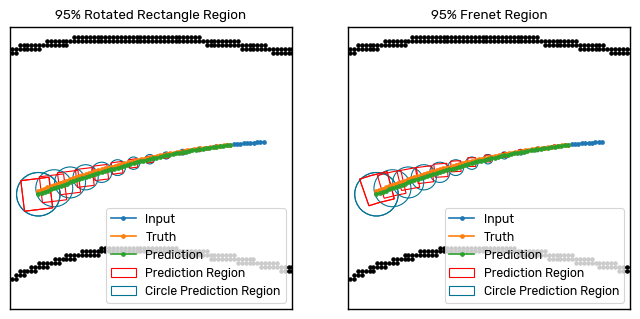

In [76]:
#sns.set_context("paper", font_scale=1.5)
fig, axs = plt.subplots(1, 2, figsize=(8,4))
input, target, prediction = input.squeeze(0).cpu(), target.squeeze(0).cpu(), output.squeeze(0).cpu()

axs[0] = create_single_plot(input.numpy(), target.numpy(), prediction.numpy(), axs[0], buffer=0.25, heading_boxes=False)

axs[0].tick_params(          
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False
    )

rot_input, rot_target, rot_output = rotate_sample(input[0].cpu(), last_pose[0].cpu(), target[0].cpu(), output[0].cpu())
rot_output += last_pose[0, :2].cpu()
boxes = list()
for i in range(-1, output.squeeze(0).shape[0], 5):
    originx, originy = rot_output[i,0].item(), rot_output[i,1].item()
    angle = rad_to_deg(last_pose[0, 2].cpu().numpy())  # Angle
    rot_origin = tuple(last_pose[0, :2].cpu().numpy()) # Last Pose Origin
    width, height = (rotated_rectangle_region['x_upper'][i]-rotated_rectangle_region['x_lower'][i], rotated_rectangle_region['y_upper'][i]-rotated_rectangle_region['y_lower'][i])
    corner = (originx+rotated_rectangle_region['x_lower'][i], originy+rotated_rectangle_region['y_lower'][i])
    # Circles
    axs[0].add_patch(plt.Circle((output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()), displacement_region['upper'][i], edgecolor='xkcd:sea blue', fill=False))
    # Rotated Rectangles
    axs[0].add_patch(plt.Rectangle(corner, width, height, edgecolor='red', fill=False, angle=angle, rotation_point=rot_origin))
axs[0].set_title("95% Rotated Rectangle Region")
handles, labels = axs[0].get_legend_handles_labels()
cp_region_patch = mpatches.Patch(edgecolor='red', fill=False, label='Prediction Region')
cp_region_patch_circle = mpatches.Patch(edgecolor='xkcd:sea blue', fill=False, label='Circle Prediction Region')
handles.append(cp_region_patch)
handles.append(cp_region_patch_circle)
axs[0].legend(handles=handles, loc='lower right')

axs[1] = create_single_plot(input.numpy(), target.numpy(), prediction.numpy(), axs[1], buffer=0.25, heading_boxes=False)
axs[1].tick_params(          
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False
    )
polygons = list()
for i in tqdm(range(-1, output.squeeze(0).shape[0], 5)):
    originx, originy = output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()
    frenet_origin = point_to_frenet(output.squeeze(0)[i,:2].cpu().numpy(), centerline)
    frenet_prog_range = np.arange(frenet_region['prog_lower'][i]+frenet_origin[0], frenet_region['prog_upper'][i]+frenet_origin[0], step=5e-2)%1000
    upper = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_upper'][i])]), centerline) for j in range(len(frenet_prog_range))]
    lower = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_lower'][i])]), centerline) for j in range(len(frenet_prog_range))]
    points = lower+upper[::-1]
    # Circles
    axs[1].add_patch(plt.Circle((output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()), displacement_region['upper'][i], edgecolor='xkcd:sea blue', fill=False))
    # Frenet
    axs[1].add_patch(plt.Polygon(np.array(points), color='red', fill=False))

axs[1].set_title("95% Frenet Region")
handles, labels = axs[0].get_legend_handles_labels()
cp_region_patch = mpatches.Patch(edgecolor='red', fill=False, label='Prediction Region')
cp_region_patch_circle = mpatches.Patch(edgecolor='xkcd:sea blue', fill=False, label='Circle Prediction Region')
handles.append(cp_region_patch)
handles.append(cp_region_patch_circle)
axs[1].legend(handles=handles, loc='lower right')

plt.savefig("plotting/cp_regions.eps", bbox_inches='tight')
plt.savefig("plotting/cp_regions.png", bbox_inches='tight')
sns.set_context("paper")

  0%|          | 0/13 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


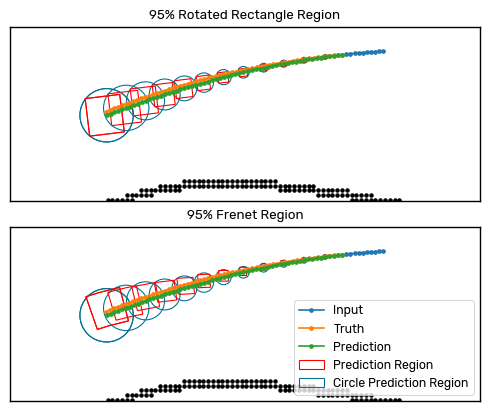

In [77]:
#sns.set_context("paper", font_scale=1.5)
fig, axs = plt.subplots(2, 1, figsize=(8,4), constrained_layout=True)
input, target, prediction = input.squeeze(0).cpu(), target.squeeze(0).cpu(), output.squeeze(0).cpu()

(linput,) = axs[0].plot(
    input[:, 0],
    input[:, 1],
    marker=".",
    label="Input",
)
(ltarget,) = axs[0].plot(
    target[:, 0],
    target[:, 1],
    marker=".",
    label="Truth",
)
(lpred,) = axs[0].plot(
    prediction[:, 0],
    prediction[:, 1],
    marker=".",
    label="Prediction",
)
axs[0].set_aspect("equal")
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()
axs[0].scatter(map_x, map_y, color="black", marker=".")
axs[0].set(
    xlim=(xlim[0] - 1, xlim[1] + 1),
    ylim=(ylim[0] - 1.0, ylim[1] + 0.25),
)
axs[0].tick_params(          
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False
    )
axs[0].set_yticklabels([])
axs[0].set_xticklabels([])

rot_input, rot_target, rot_output = rotate_sample(input[0].cpu(), last_pose[0].cpu(), target[0].cpu(), output[0].cpu())
rot_output += last_pose[0, :2].cpu()
boxes = list()
for i in range(-1, output.squeeze(0).shape[0], 5):
    originx, originy = rot_output[i,0].item(), rot_output[i,1].item()
    angle = rad_to_deg(last_pose[0, 2].cpu().numpy())  # Angle
    rot_origin = tuple(last_pose[0, :2].cpu().numpy()) # Last Pose Origin
    width, height = (rotated_rectangle_region['x_upper'][i]-rotated_rectangle_region['x_lower'][i], rotated_rectangle_region['y_upper'][i]-rotated_rectangle_region['y_lower'][i])
    corner = (originx+rotated_rectangle_region['x_lower'][i], originy+rotated_rectangle_region['y_lower'][i])
    # Circles
    axs[0].add_patch(plt.Circle((output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()), displacement_region['upper'][i], edgecolor='xkcd:sea blue', fill=False))
    # Rotated Rectangles
    axs[0].add_patch(plt.Rectangle(corner, width, height, edgecolor='red', fill=False, angle=angle, rotation_point=rot_origin))
axs[0].set_title("95% Rotated Rectangle Region")
handles, labels = axs[0].get_legend_handles_labels()
cp_region_patch = mpatches.Patch(edgecolor='red', fill=False, label='Prediction Region')
cp_region_patch_circle = mpatches.Patch(edgecolor='xkcd:sea blue', fill=False, label='Circle Prediction Region')
handles.append(cp_region_patch)
handles.append(cp_region_patch_circle)
#axs[0].legend(handles=handles, loc='lower right')

(linput,) = axs[1].plot(
    input[:, 0],
    input[:, 1],
    marker=".",
    label="Input",
)
(ltarget,) = axs[1].plot(
    target[:, 0],
    target[:, 1],
    marker=".",
    label="Truth",
)
(lpred,) = axs[1].plot(
    prediction[:, 0],
    prediction[:, 1],
    marker=".",
    label="Prediction",
)
xlim = axs[1].get_xlim()
ylim = axs[1].get_ylim()
axs[1].scatter(map_x, map_y, color="black", marker=".")
axs[1].set(
    xlim=(xlim[0] - 1, xlim[1] + 1),
    ylim=(ylim[0] - 1.0, ylim[1] + 0.25),
)
axs[1].tick_params(          
        axis='both',
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False
    )
axs[1].set_aspect("equal")
axs[1].set_yticklabels([])
axs[1].set_xticklabels([])

polygons = list()
for i in tqdm(range(-1, output.squeeze(0).shape[0], 5)):
    originx, originy = output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()
    frenet_origin = point_to_frenet(output.squeeze(0)[i,:2].cpu().numpy(), centerline)
    frenet_prog_range = np.arange(frenet_region['prog_lower'][i]+frenet_origin[0], frenet_region['prog_upper'][i]+frenet_origin[0], step=5e-2)%1000
    upper = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_upper'][i])]), centerline) for j in range(len(frenet_prog_range))]
    lower = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_lower'][i])]), centerline) for j in range(len(frenet_prog_range))]
    points = lower+upper[::-1]
    # Circles
    axs[1].add_patch(plt.Circle((output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()), displacement_region['upper'][i], edgecolor='xkcd:sea blue', fill=False))
    # Frenet
    axs[1].add_patch(plt.Polygon(np.array(points), color='red', fill=False))

axs[1].set_title("95% Frenet Region")
handles, labels = axs[0].get_legend_handles_labels()
cp_region_patch = mpatches.Patch(edgecolor='red', fill=False, label='Prediction Region')
cp_region_patch_circle = mpatches.Patch(edgecolor='xkcd:sea blue', fill=False, label='Circle Prediction Region')
handles.append(cp_region_patch)
handles.append(cp_region_patch_circle)
axs[1].legend(handles=handles, loc='lower right')

plt.savefig("plotting/cp_regions.eps", bbox_inches='tight')
plt.savefig("plotting/cp_regions.png", bbox_inches='tight')
sns.set_context("paper")

In [78]:
from vmp.data_utils import VAL_LIST
IDX = 43226#VAL_LIST[3]
with torch.no_grad():
    input = torch.tensor(full_frame.loc[IDX]['input_vel'], device=DEVICE).unsqueeze(0)
    target = torch.tensor(full_frame.loc[IDX]['target'], device=DEVICE).unsqueeze(0)
    last_pose = torch.tensor(full_frame.loc[IDX]['last_pose'], device=DEVICE).unsqueeze(0)
    output, _ = net.predict(input, last_pose, control_input_bias=control_input_bias)
    lstm_output = lstm_net.predict(input, last_pose)

  0%|          | 0/13 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


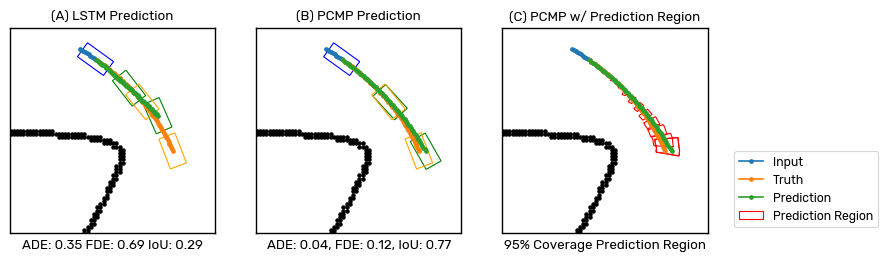

In [114]:
#sns.set_context("paper", font_scale=1.5)
fig, axs = plt.subplots(1,3, figsize=(9,6), constrained_layout=False)
input, target, prediction = input.squeeze(0).cpu(), target.squeeze(0).cpu(), output.squeeze(0).cpu()
lstm_output = lstm_output.squeeze(0).cpu()

axs[0] = create_single_plot(input.numpy(), target.numpy(), lstm_output.numpy(), axs[0], buffer=0.6)
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()
xlim=(xlim[0] - 0.35, xlim[1] - 0.35)
ylim=(ylim[0] - 0.45, ylim[1] - 0.45)
axs[0].set(
    xlim=xlim,
    ylim=ylim,
)
axs[0].set_xlabel(f"ADE: {average_displacement_error(lstm_output, target):.2f} FDE: {final_displacement_error(lstm_output, target):.2f} IoU: {iou_single_pred(lstm_output, target):.2f}",
                 {
                     'family': 'Rubik',
                     'weight': 'normal',
                     'stretch': 'condensed'
                 }
)
#axs[0].legend(loc="lower left")
axs[0].set_title("(A) LSTM Prediction")

axs[1] = create_single_plot(input.numpy(), target.numpy(), prediction.numpy(), axs[1], buffer=0.6)
axs[1].set(
    xlim=xlim,
    ylim=ylim,
)
rot_input, rot_target, rot_output = rotate_sample(input[0].cpu(), last_pose[0].cpu(), target[0].cpu(), output[0].cpu())
rot_output += last_pose[0, :2].cpu()
boxes = list()
for i in range(-1, output.squeeze(0).shape[0], 5):
    originx, originy = rot_output[i,0].item(), rot_output[i,1].item()
    angle = rad_to_deg(last_pose[0, 2].cpu().numpy())  # Angle
    rot_origin = tuple(last_pose[0, :2].cpu().numpy()) # Last Pose Origin
    width, height = (rotated_rectangle_region['x_upper'][i]-rotated_rectangle_region['x_lower'][i], rotated_rectangle_region['y_upper'][i]-rotated_rectangle_region['y_lower'][i])
    corner = (originx+rotated_rectangle_region['x_lower'][i], originy+rotated_rectangle_region['y_lower'][i])
axs[1].set_title("(B) PCMP Prediction")
#axs[1].legend(loc="lower left")
axs[1].set_xlabel(f"ADE: {average_displacement_error(prediction, target):.2f}, FDE: {final_displacement_error(prediction, target):.2f}, IoU: {iou_single_pred(prediction, target):.2f}",
                 {
                     'family': 'Rubik',
                     'weight': 'normal',
                     'stretch': 'condensed'
                 }
)

axs[2] = create_single_plot(input.numpy(), target.numpy(), prediction.numpy(), axs[2], buffer=0.6, heading_boxes=False)
axs[2].set(
    xlim=xlim,
    ylim=ylim,
)
polygons = list()
for i in tqdm(range(-1, output.squeeze(0).shape[0], 5)):
    originx, originy = output.squeeze(0)[i,0].item(), output.squeeze(0)[i,1].item()
    frenet_origin = point_to_frenet(output.squeeze(0)[i,:2].cpu().numpy(), centerline)
    frenet_prog_range = np.arange(frenet_region['prog_lower'][i]+frenet_origin[0], frenet_region['prog_upper'][i]+frenet_origin[0], step=5e-2)%1000
    upper = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_upper'][i])]), centerline) for j in range(len(frenet_prog_range))]
    lower = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_lower'][i])]), centerline) for j in range(len(frenet_prog_range))]
    points = lower+upper[::-1]
    # Frenet
    axs[2].add_patch(plt.Polygon(np.array(points), color='red', fill=False))

axs[2].set_title("(C) PCMP w/ Prediction Region")
handles, labels = axs[0].get_legend_handles_labels()
cp_region_patch = mpatches.Patch(edgecolor='red', fill=False, label='Prediction Region')
handles.append(cp_region_patch)
axs[2].set_xlabel(f"95% Coverage Prediction Region",
                 {
                     'family': 'Rubik',
                     'weight': 'normal',
                     'stretch': 'condensed'
                 }
)
axs[2].legend(handles=handles, loc='lower left', bbox_to_anchor=(1.1,0))


plt.savefig("plotting/progression.eps", bbox_inches='tight')
plt.savefig("plotting/progression.png", bbox_inches='tight')
sns.set_context("paper")

In [80]:
f"LSTM ADE: {average_displacement_error(lstm_output, target):.4f}, FDE: {final_displacement_error(lstm_output, target):.4f}, IoU: {iou_single_pred(lstm_output, target):.4f}"

'LSTM ADE: 0.3464, FDE: 0.6926, IoU: 0.2938'

In [81]:
f"PIMP ADE: {average_displacement_error(prediction, target):.4f}, FDE: {final_displacement_error(prediction, target):.4f}, IoU: {iou_single_pred(prediction, target):.4f}"

'PIMP ADE: 0.0424, FDE: 0.1238, IoU: 0.7747'

In [82]:
from vmp.data_utils import TRAIN_LIST, TEST_LIST, VAL_LIST, RACE_TEST_LIST

selection = VAL_LIST
inputs, last_poses, targets = val_dataset[: len(selection)]
inputs = torch.zeros_like(inputs, dtype=torch.float32, device=DEVICE)
last_poses = torch.zeros_like(last_poses, dtype=torch.float32, device=DEVICE)
for i, DATA_IDX in enumerate(selection):
    dframe = full_frame
    inputs[i] = torch.tensor(
        dframe.loc[DATA_IDX]["input_vel"], dtype=torch.float32, device=DEVICE
    )
    last_poses[i] = torch.tensor(
        dframe.loc[DATA_IDX]["last_pose"], dtype=torch.float32, device=DEVICE
    )
    targets[i] = torch.tensor(
        dframe.loc[DATA_IDX]["target"], dtype=torch.float32, device=DEVICE
    )

outputs, _ = net.predict(inputs, last_poses)
outputs = outputs.detach().cpu().numpy()

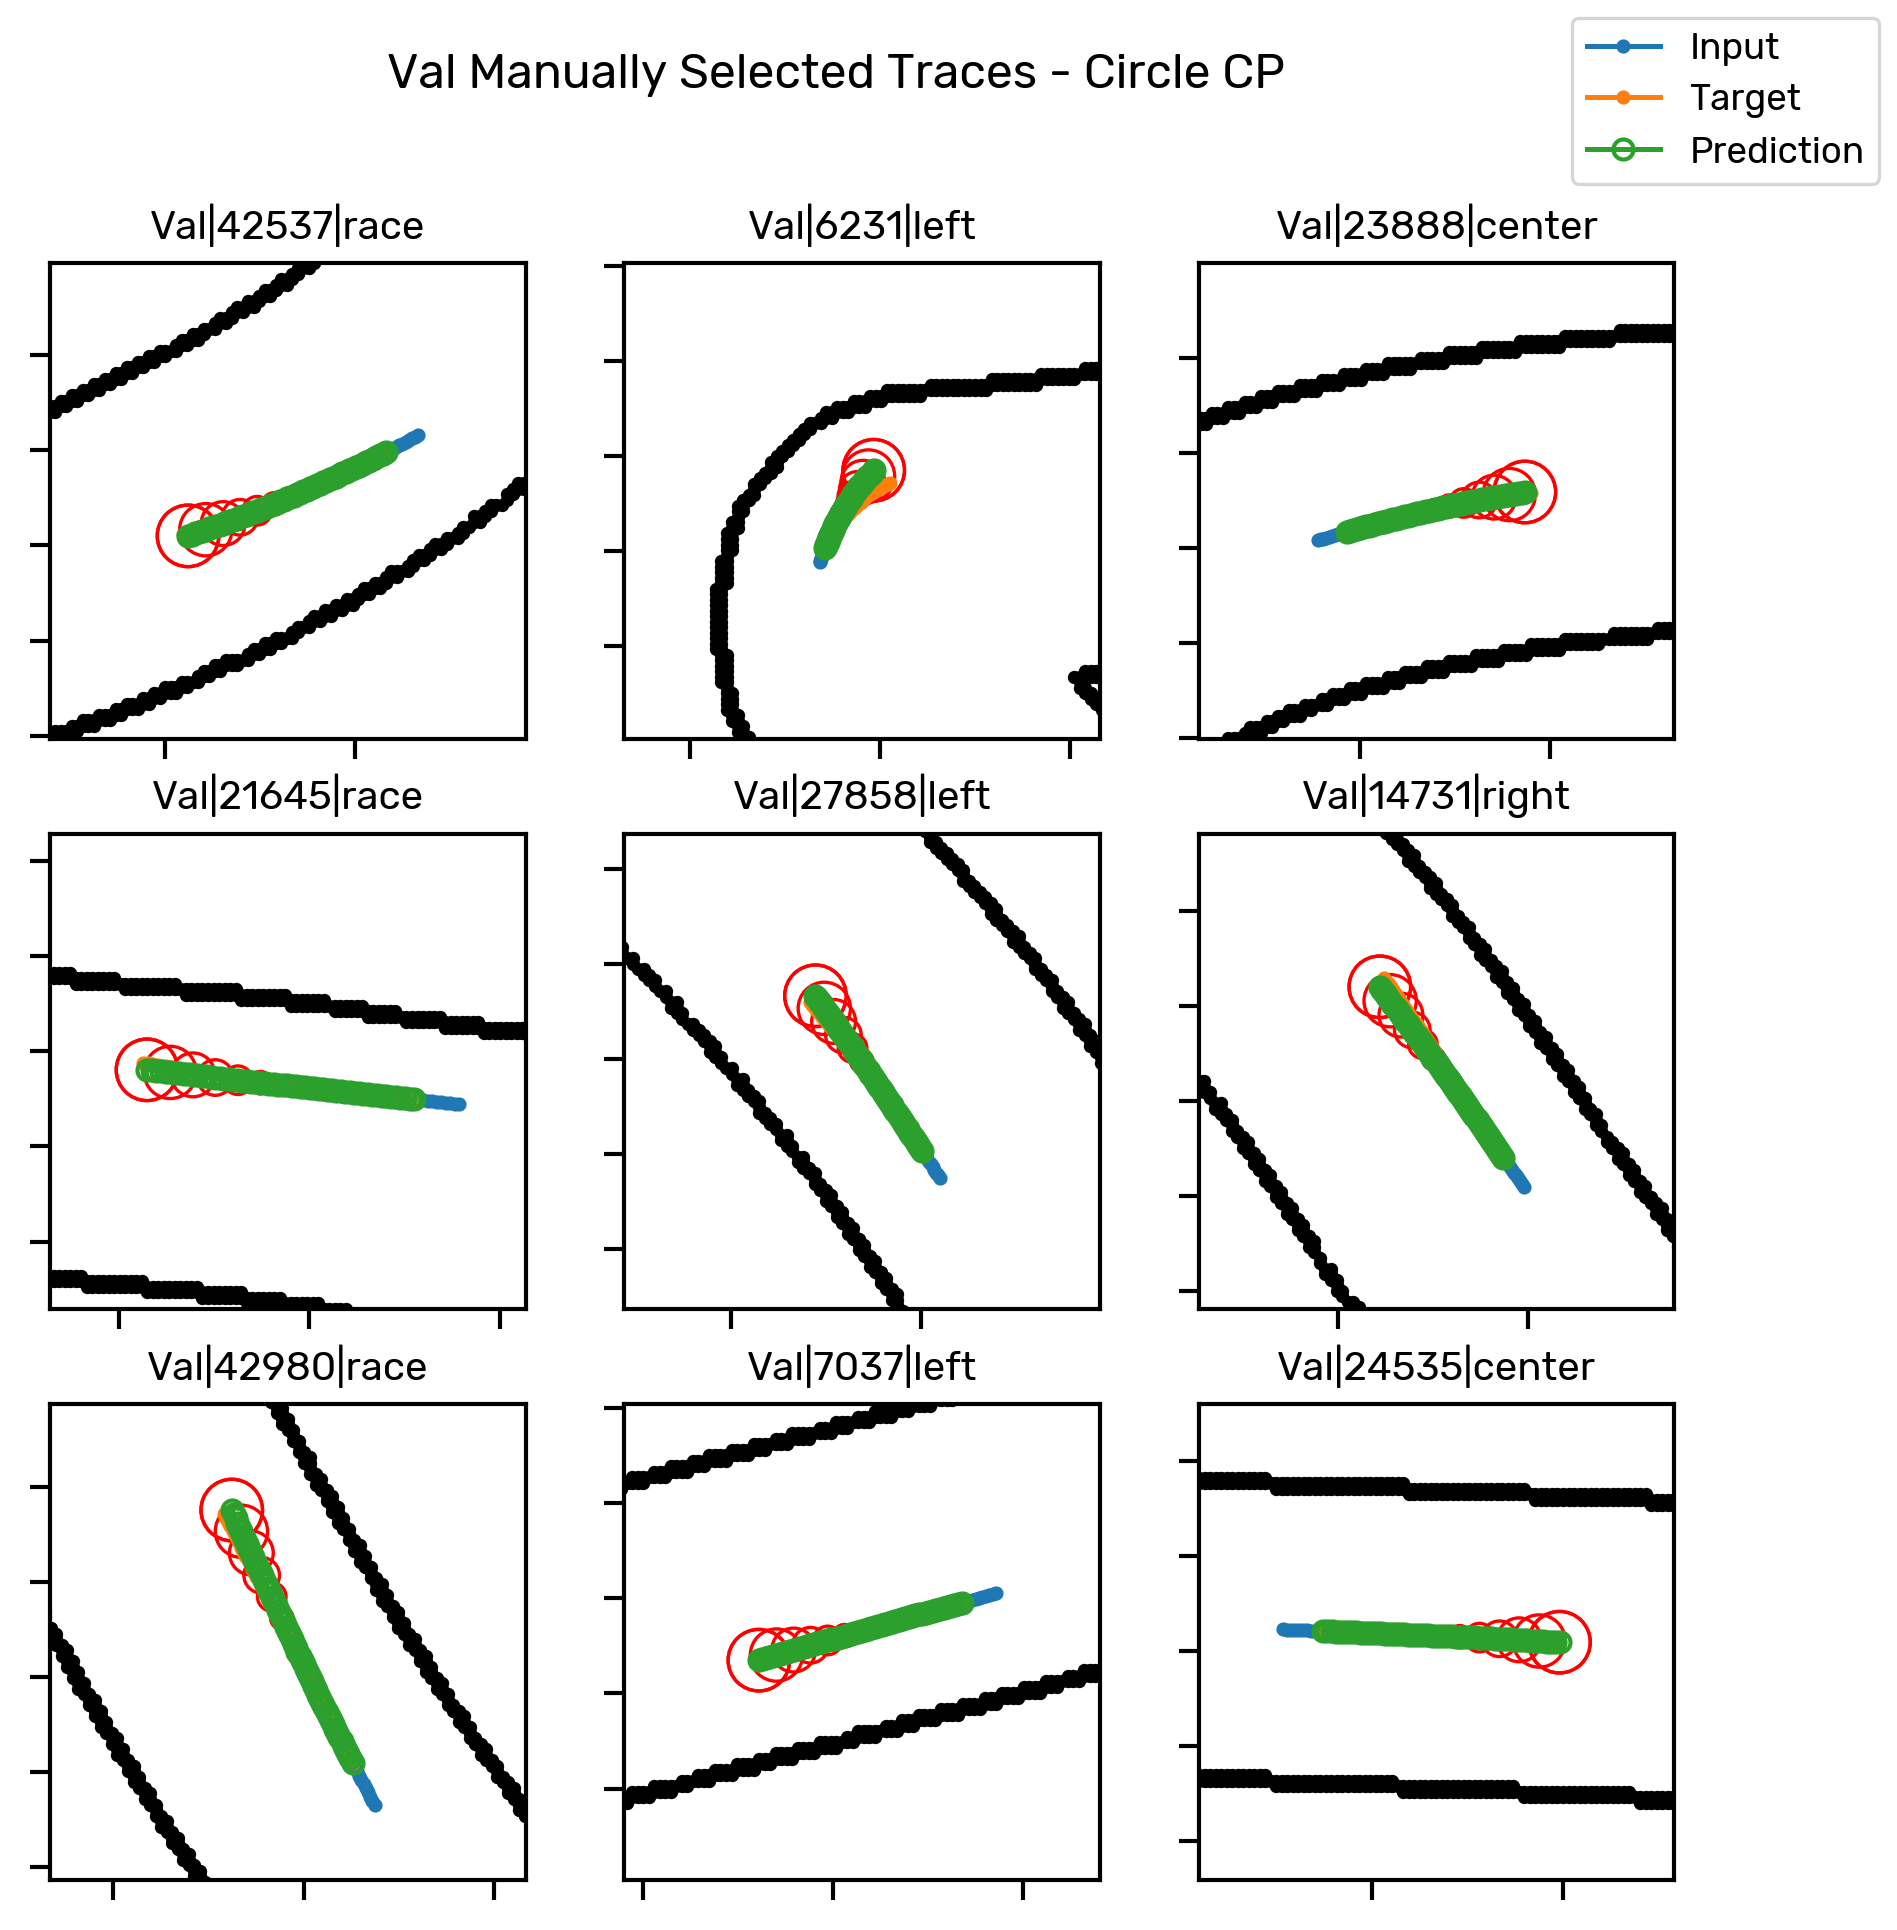

In [83]:
fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=300)
for idx, DATA_IDX in enumerate(selection):
    data_in_set = "Train" if DATA_IDX in train_dataset.dataframe.index else False
    if not data_in_set:
        data_in_set = "Test" if DATA_IDX in test_dataset.dataframe.index else "Val"
    dframe = full_frame
    (linput,) = axs[idx // 3, idx % 3].plot(
        dframe.loc[DATA_IDX]["input"][:, 0],
        dframe.loc[DATA_IDX]["input"][:, 1],
        marker=".",
        label="Input",
    )
    (ltarget,) = axs[idx // 3, idx % 3].plot(
        dframe.loc[DATA_IDX]["target"][:, 0],
        dframe.loc[DATA_IDX]["target"][:, 1],
        marker=".",
        label="Target",
    )
    (lpred,) = axs[idx // 3, idx % 3].plot(
        outputs[idx, :, 0],
        outputs[idx, :, 1],
        marker="o",
        mfc="none",
        label="Prediction",
    )
    circles = list()
    for i in range(-1, outputs[idx].shape[0], 5):
        # for the tenth one, draw the tenth circle
        circles.append(plt.Circle((outputs[idx,i,0].item(), outputs[idx,i,1].item()), displacement_region['upper'][i], edgecolor='red', fill=False))
    for circle in circles:
        axs[idx // 3, idx % 3].add_patch(circle)
    xlim = axs[idx // 3, idx % 3].get_xlim()
    ylim = axs[idx // 3, idx % 3].get_ylim()
    max_offset_x = max(np.mean(xlim)-xlim[0], xlim[1]-np.mean(xlim))
    max_offset_y = max(np.mean(ylim)-ylim[0], ylim[1]-np.mean(ylim))
    max_offset = max(max_offset_x, max_offset_y)
    max_offset = max(max_offset, 2.5)
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color="black")
    axs[idx // 3, idx % 3].set(
        xlim=(np.mean(xlim) - max_offset, np.mean(xlim) + max_offset),
        ylim=(np.mean(ylim) - max_offset, np.mean(ylim) + max_offset),
        aspect=1.0,
        adjustable="box",
        yticklabels=[],
        xticklabels=[],
    )
    axs[idx // 3, idx % 3].set_title(
        "{}|{}|{}".format(
            data_in_set,
            DATA_IDX,
            dframe.loc[DATA_IDX]["selected_lane"],
        )
    )
fig.suptitle(f"{data_in_set} Manually Selected Traces - Circle CP")
fig.legend(handles=[linput, ltarget, lpred])


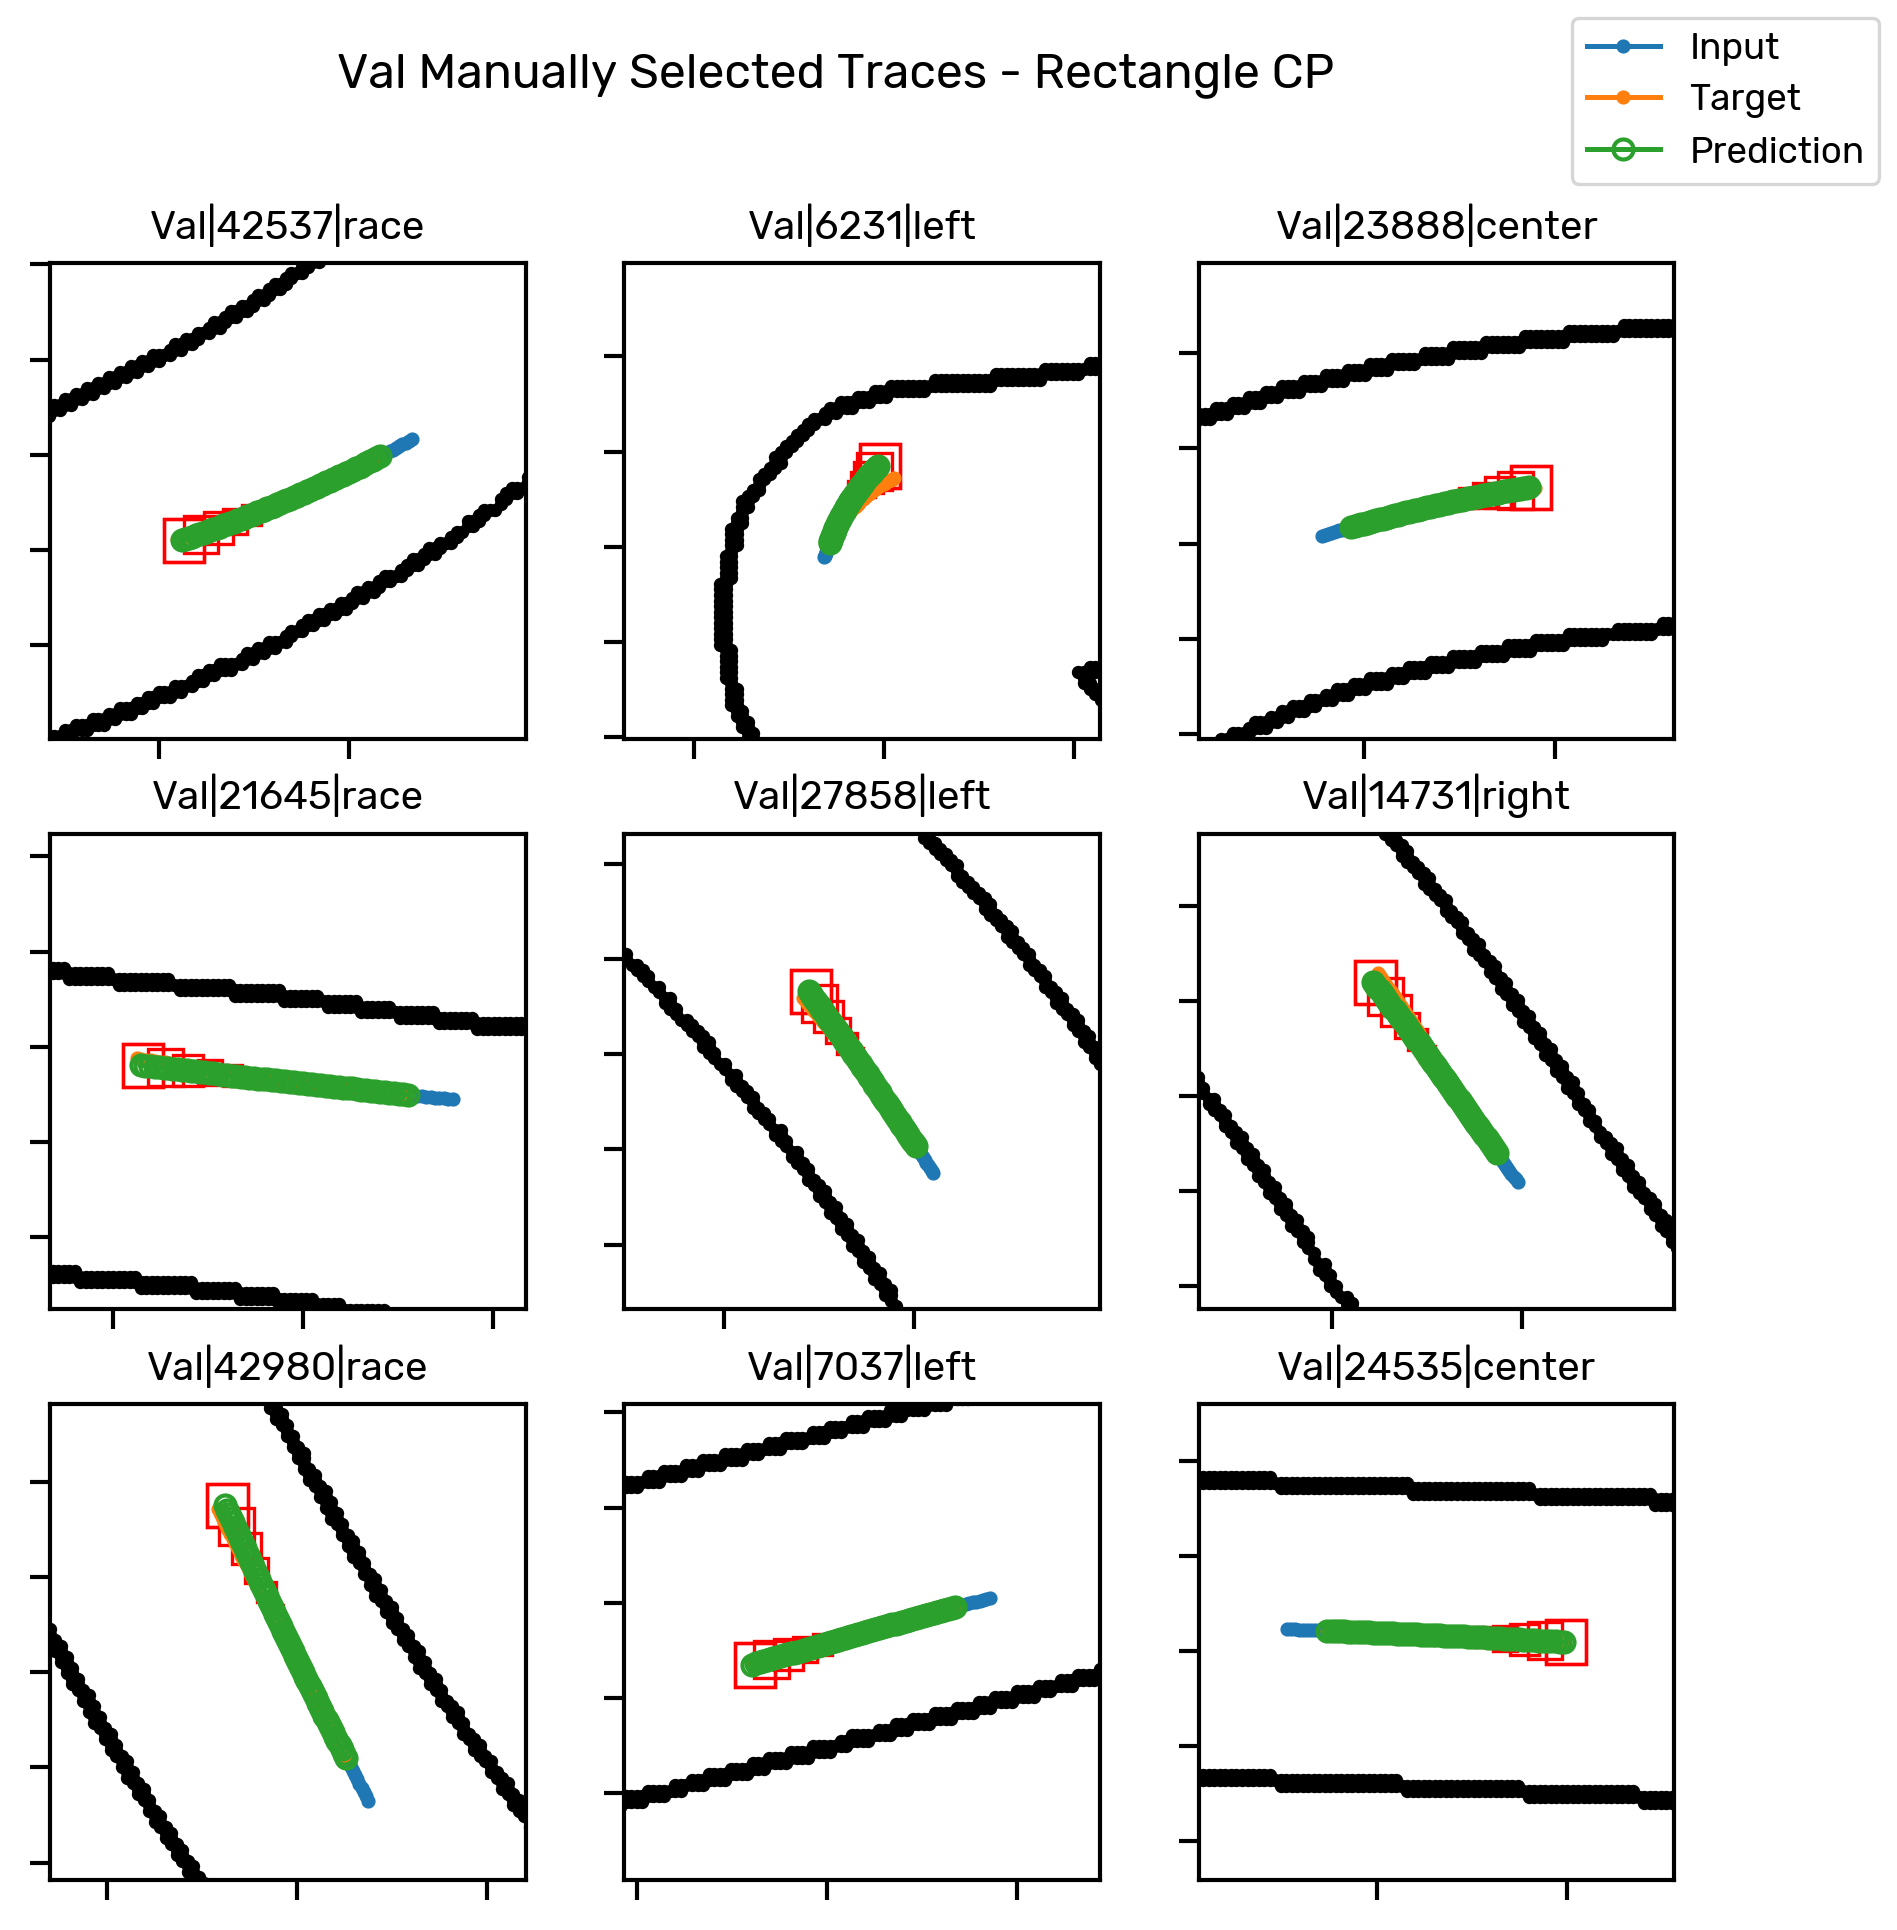

In [84]:
fig, axs = plt.subplots(3, 3, figsize=(7, 7), dpi=300)
for idx, DATA_IDX in enumerate(selection):
    data_in_set = "Train" if DATA_IDX in train_dataset.dataframe.index else False
    if not data_in_set:
        data_in_set = "Test" if DATA_IDX in test_dataset.dataframe.index else "Val"
    dframe = full_frame
    (linput,) = axs[idx // 3, idx % 3].plot(
        dframe.loc[DATA_IDX]["input"][:, 0],
        dframe.loc[DATA_IDX]["input"][:, 1],
        marker=".",
        label="Input",
    )
    (ltarget,) = axs[idx // 3, idx % 3].plot(
        dframe.loc[DATA_IDX]["target"][:, 0],
        dframe.loc[DATA_IDX]["target"][:, 1],
        marker=".",
        label="Target",
    )
    (lpred,) = axs[idx // 3, idx % 3].plot(
        outputs[idx, :, 0],
        outputs[idx, :, 1],
        marker="o",
        mfc="none",
        label="Prediction",
    )
    boxes = list()
    for i in range(-1, outputs[idx].shape[0], 5):
        # for the tenth one, draw the tenth circle
        originx, originy = outputs[idx,i,0].item(), outputs[idx,i,1].item()
        bounds = ((originx+rectangle_region['x_lower'][i], originx+rectangle_region['x_upper'][i]), (originy+rectangle_region['y_lower'][i], originy+rectangle_region['y_upper'][i]))
        width, height = (bounds[0][1]-bounds[0][0], bounds[1][1]-bounds[1][0])
        corner = (bounds[0][0], bounds[1][0])
        boxes.append(plt.Rectangle(corner, width, height, edgecolor='red', fill=False))
    for box in boxes:
        axs[idx // 3, idx % 3].add_patch(box)
    xlim = axs[idx // 3, idx % 3].get_xlim()
    ylim = axs[idx // 3, idx % 3].get_ylim()
    max_offset_x = max(np.mean(xlim)-xlim[0], xlim[1]-np.mean(xlim))
    max_offset_y = max(np.mean(ylim)-ylim[0], ylim[1]-np.mean(ylim))
    max_offset = max(max_offset_x, max_offset_y)
    max_offset = max(max_offset, 2.5)
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color="black")
    axs[idx // 3, idx % 3].set(
        xlim=(np.mean(xlim) - max_offset, np.mean(xlim) + max_offset),
        ylim=(np.mean(ylim) - max_offset, np.mean(ylim) + max_offset),
        aspect=1.0,
        adjustable="box",
        yticklabels=[],
        xticklabels=[],
    )
    axs[idx // 3, idx % 3].set_title(
        "{}|{}|{}".format(
            data_in_set,
            DATA_IDX,
            dframe.loc[DATA_IDX]["selected_lane"],
        )
    )
fig.suptitle(f"{data_in_set} Manually Selected Traces - Rectangle CP")
fig.legend(handles=[linput, ltarget, lpred])


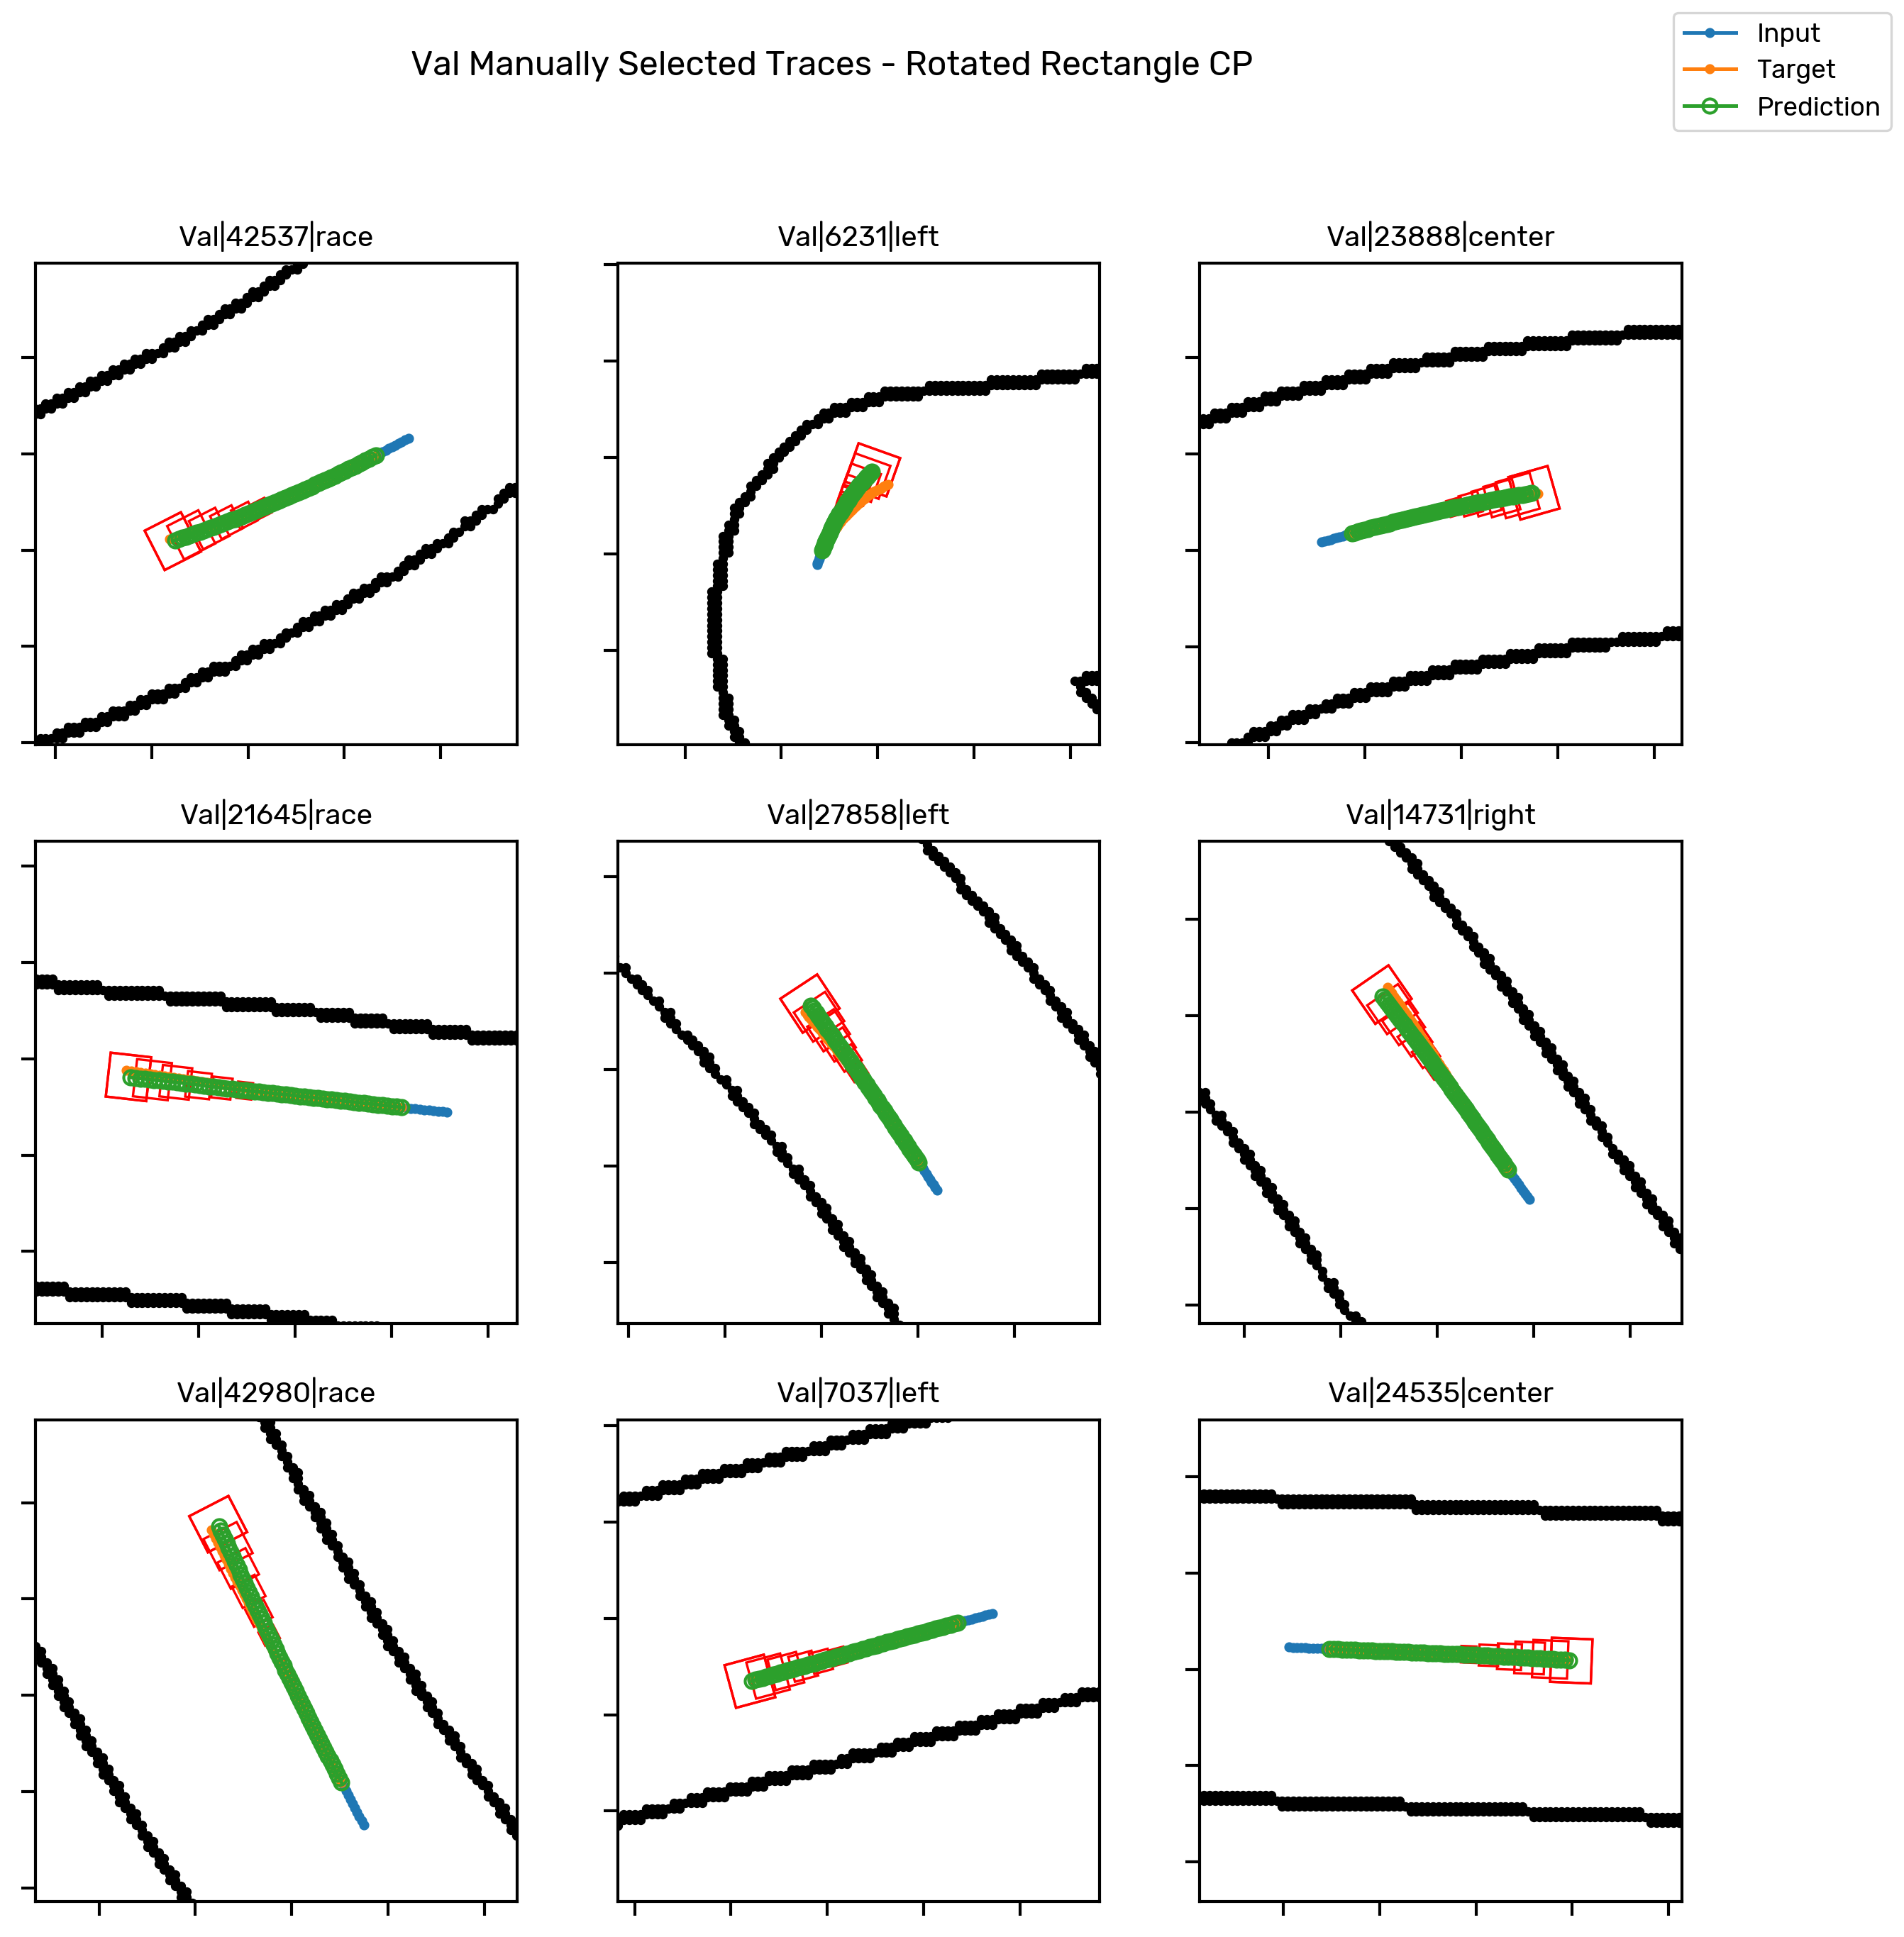

In [85]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=300)
for idx, DATA_IDX in enumerate(selection):
    data_in_set = "Train" if DATA_IDX in train_dataset.dataframe.index else False
    if not data_in_set:
        data_in_set = "Test" if DATA_IDX in test_dataset.dataframe.index else "Val"
    dframe = full_frame
    (linput,) = axs[idx // 3, idx % 3].plot(
        dframe.loc[DATA_IDX]["input"][:, 0],
        dframe.loc[DATA_IDX]["input"][:, 1],
        marker=".",
        label="Input",
    )
    (ltarget,) = axs[idx // 3, idx % 3].plot(
        dframe.loc[DATA_IDX]["target"][:, 0],
        dframe.loc[DATA_IDX]["target"][:, 1],
        marker=".",
        label="Target",
    )
    (lpred,) = axs[idx // 3, idx % 3].plot(
        outputs[idx, :, 0],
        outputs[idx, :, 1],
        marker="o",
        mfc="none",
        label="Prediction",
    )
    boxes = list()
    rot_input, rot_target, rot_output = rotate_sample(inputs[idx].cpu(), last_poses[idx].cpu(), targets[idx].cpu(), torch.tensor(outputs[idx]))
    rot_output += last_poses[idx, :2].cpu()
    for i in range(-1, outputs[idx].shape[0], 5):
        originx, originy = rot_output[i,0].item(), rot_output[i,1].item()
        angle = rad_to_deg(last_poses[idx, 2].cpu().numpy())  # Angle
        rot_origin = tuple(last_poses[idx, :2].cpu().numpy())
        width, height = (rotated_rectangle_region['x_upper'][i]-rotated_rectangle_region['x_lower'][i], rotated_rectangle_region['y_upper'][i]-rotated_rectangle_region['y_lower'][i])
        corner = (originx+rotated_rectangle_region['x_lower'][i], originy+rotated_rectangle_region['y_lower'][i])
        boxes.append(plt.Rectangle(corner, width, height, edgecolor='red', fill=False, angle=angle, rotation_point=rot_origin))
    for box in boxes:
        axs[idx // 3, idx % 3].add_patch(box)
    xlim = axs[idx // 3, idx % 3].get_xlim()
    ylim = axs[idx // 3, idx % 3].get_ylim()
    max_offset_x = max(np.mean(xlim)-xlim[0], xlim[1]-np.mean(xlim))
    max_offset_y = max(np.mean(ylim)-ylim[0], ylim[1]-np.mean(ylim))
    max_offset = max(max_offset_x, max_offset_y)
    max_offset = max(max_offset, 2.5)
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color="black")
    axs[idx // 3, idx % 3].set(
        xlim=(np.mean(xlim) - max_offset, np.mean(xlim) + max_offset),
        ylim=(np.mean(ylim) - max_offset, np.mean(ylim) + max_offset),
        aspect=1.0,
        adjustable="box",
        yticklabels=[],
        xticklabels=[],
    )
    axs[idx // 3, idx % 3].set_title(
        "{}|{}|{}".format(
            data_in_set,
            DATA_IDX,
            dframe.loc[DATA_IDX]["selected_lane"],
        )
    )
fig.suptitle(f"{data_in_set} Manually Selected Traces - Rotated Rectangle CP")
fig.legend(handles=[linput, ltarget, lpred])


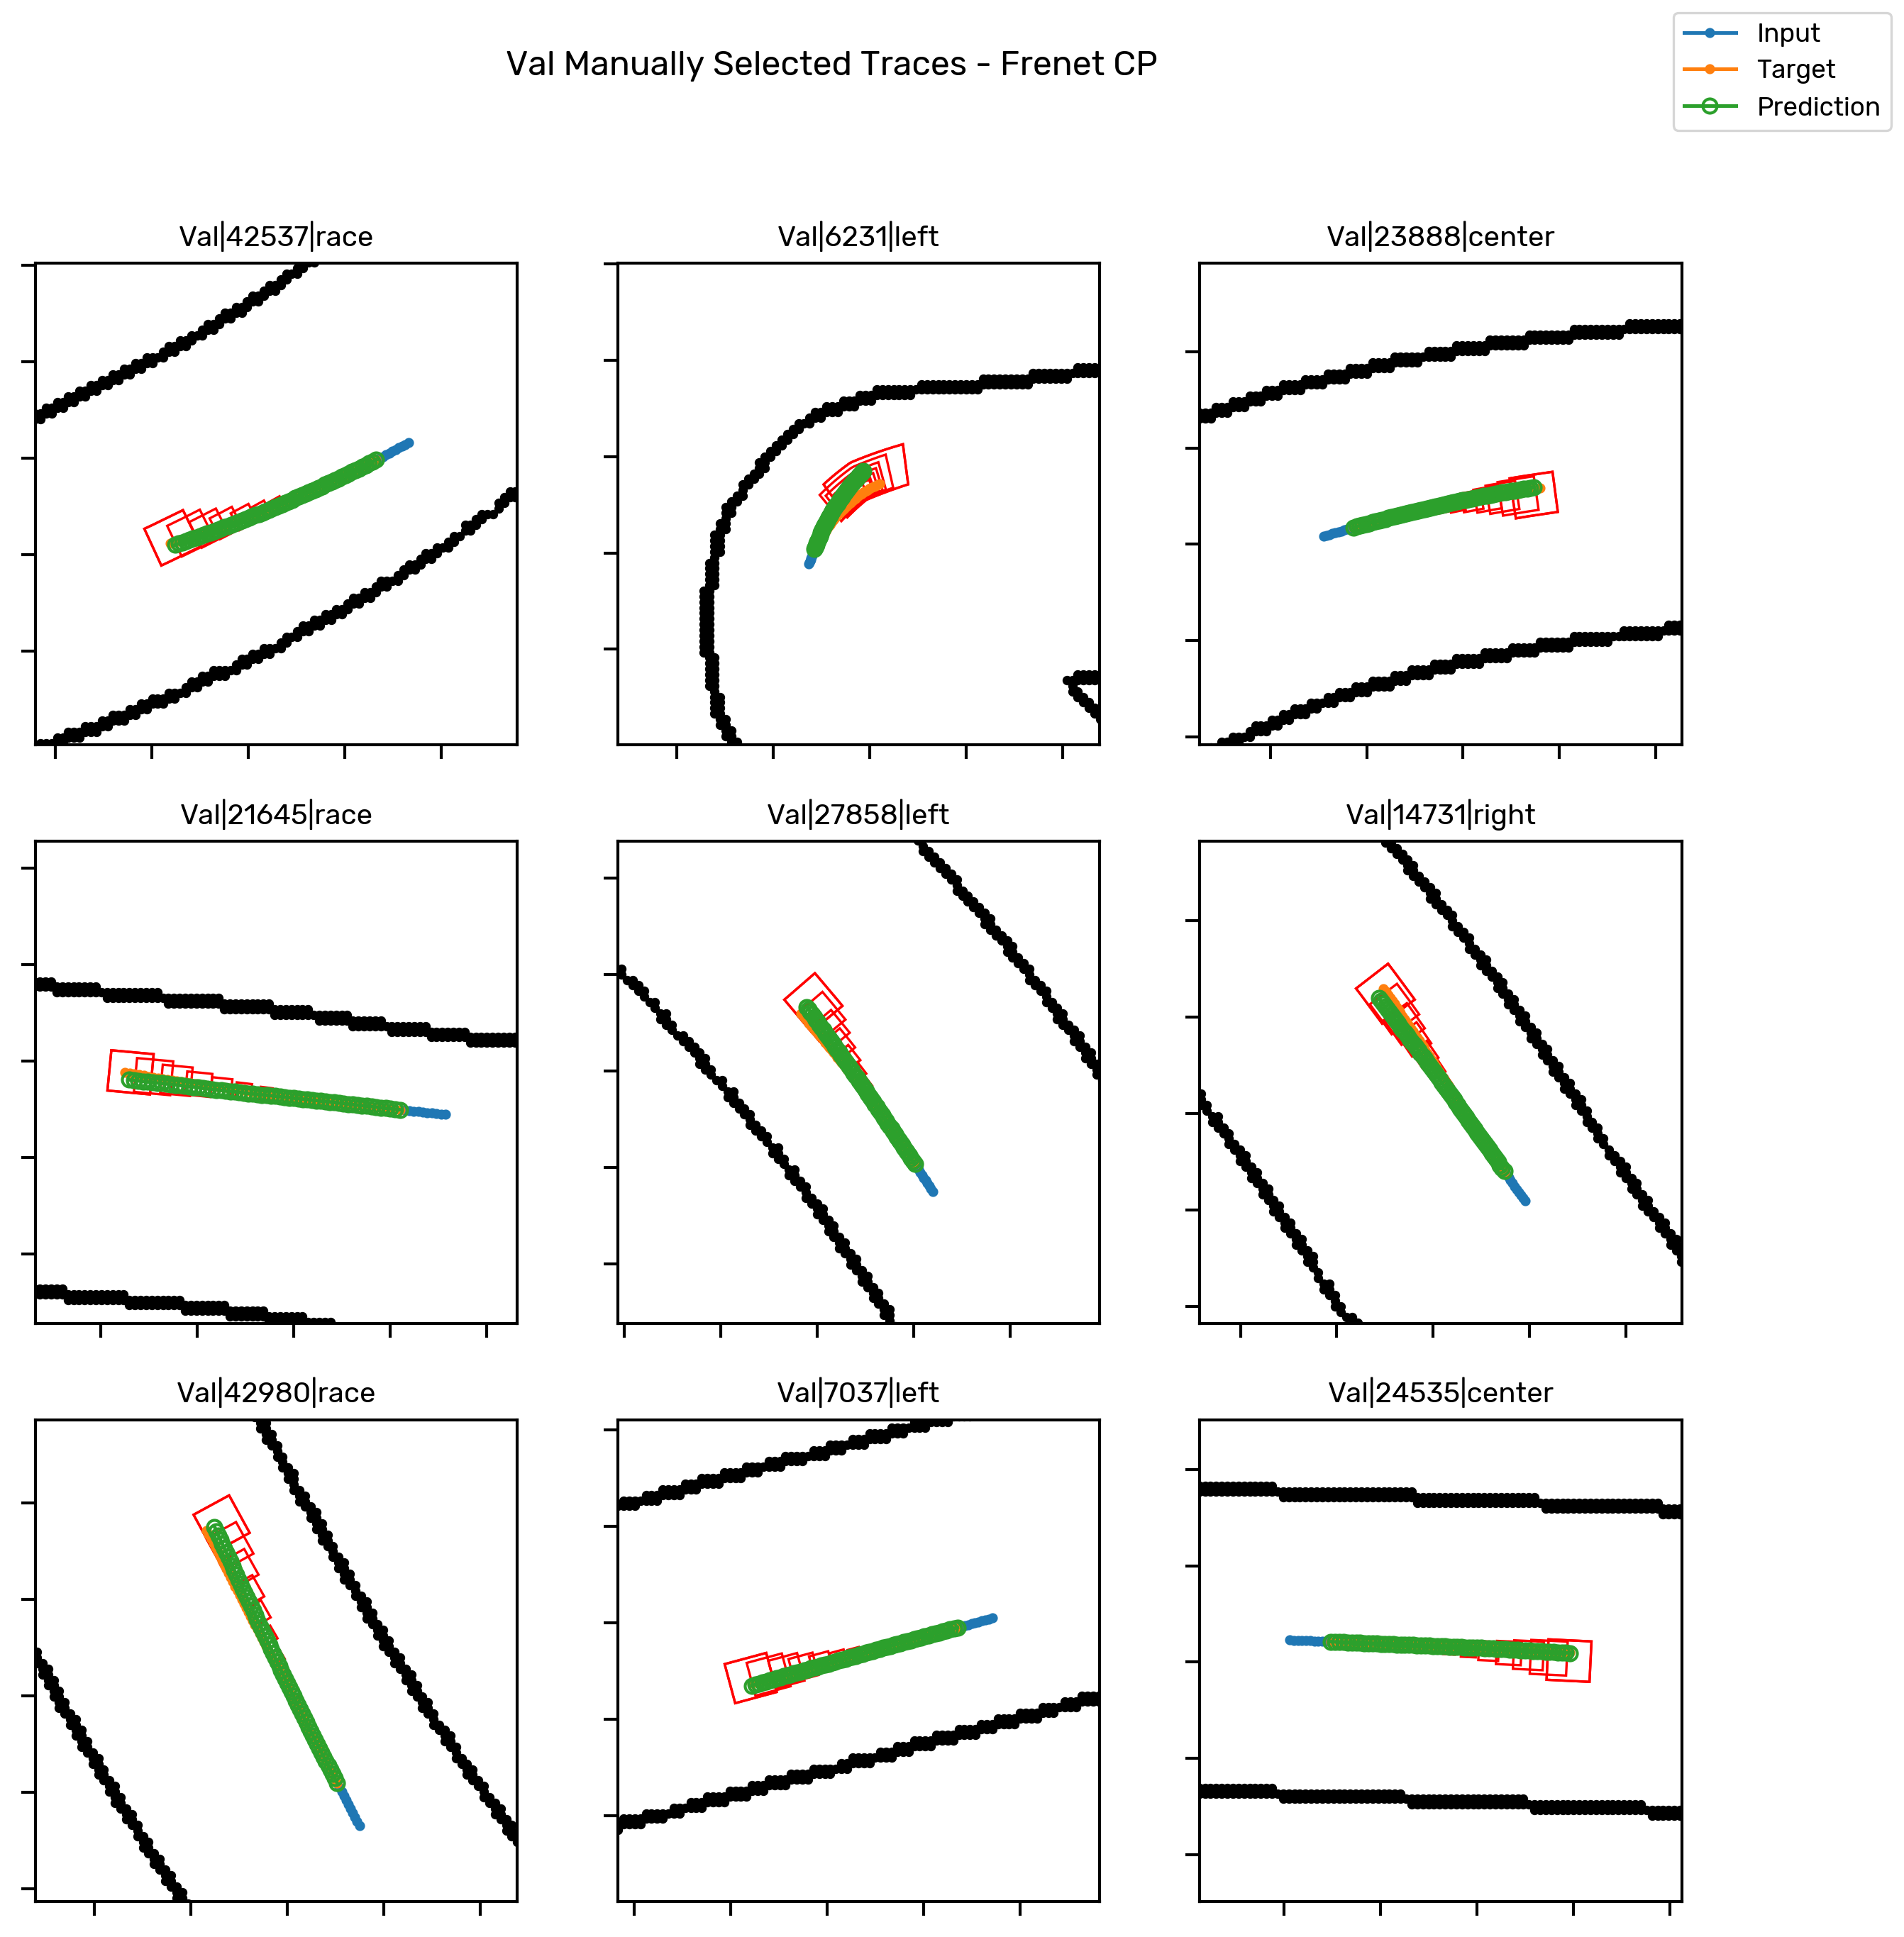

In [86]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=300)
for idx, DATA_IDX in enumerate(selection):
    data_in_set = "Train" if DATA_IDX in train_dataset.dataframe.index else False
    if not data_in_set:
        data_in_set = "Test" if DATA_IDX in test_dataset.dataframe.index else "Val"
    dframe = full_frame
    (linput,) = axs[idx // 3, idx % 3].plot(
        dframe.loc[DATA_IDX]["input"][:, 0],
        dframe.loc[DATA_IDX]["input"][:, 1],
        marker=".",
        label="Input",
    )
    (ltarget,) = axs[idx // 3, idx % 3].plot(
        dframe.loc[DATA_IDX]["target"][:, 0],
        dframe.loc[DATA_IDX]["target"][:, 1],
        marker=".",
        label="Target",
    )
    (lpred,) = axs[idx // 3, idx % 3].plot(
        outputs[idx, :, 0],
        outputs[idx, :, 1],
        marker="o",
        mfc="none",
        label="Prediction",
    )
    polygons = list()
    for i in range(-1, outputs[idx].shape[0], 5):
        originx, originy = outputs[idx, i, 0].item(), outputs[idx, i, 1].item()
        frenet_origin = point_to_frenet(outputs[idx, i, :2], centerline)
        frenet_prog_range = np.arange(frenet_region['prog_lower'][i]+frenet_origin[0], frenet_region['prog_upper'][i]+frenet_origin[0], step=5e-2)%1000
        upper = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_upper'][i])]), centerline) for j in range(len(frenet_prog_range))]
        lower = [frenet_to_point(np.array([frenet_prog_range[j], (frenet_origin[1]+frenet_region['disp_lower'][i])]), centerline) for j in range(len(frenet_prog_range))]
        points = lower+upper[::-1]
        polygons.append(plt.Polygon(np.array(points), color='red', fill=False))
    for poly in polygons:
        axs[idx // 3, idx % 3].add_patch(poly)
    xlim = axs[idx // 3, idx % 3].get_xlim()
    ylim = axs[idx // 3, idx % 3].get_ylim()
    max_offset_x = max(np.mean(xlim)-xlim[0], xlim[1]-np.mean(xlim))
    max_offset_y = max(np.mean(ylim)-ylim[0], ylim[1]-np.mean(ylim))
    max_offset = max(max_offset_x, max_offset_y)
    max_offset = max(max_offset, 2.5)
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color="black")
    axs[idx // 3, idx % 3].set(
        xlim=(np.mean(xlim) - max_offset, np.mean(xlim) + max_offset),
        ylim=(np.mean(ylim) - max_offset, np.mean(ylim) + max_offset),
        aspect=1.0,
        adjustable="box",
        yticklabels=[],
        xticklabels=[],
    )
    axs[idx // 3, idx % 3].set_title(
        "{}|{}|{}".format(
            data_in_set,
            DATA_IDX,
            dframe.loc[DATA_IDX]["selected_lane"],
        )
    )
fig.suptitle(f"{data_in_set} Manually Selected Traces - Frenet CP")
fig.legend(handles=[linput, ltarget, lpred])


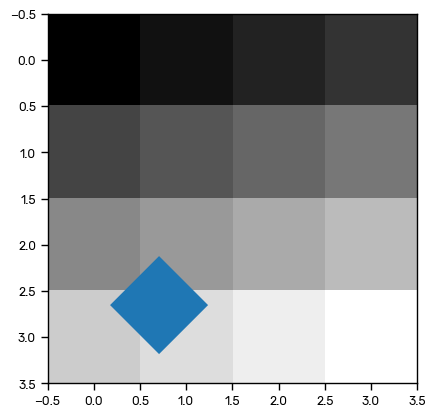

In [87]:
# The image
X = np.arange(16).reshape(4, 4)
# highlight some feature in the
# middle boxes.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(X, cmap = plt.cm.gray,
          interpolation ='nearest')
ax.add_patch(plt.Rectangle((2, 1), 0.75, 0.75, angle=45, rotation_point=(0,0)))
plt.show()

In [95]:
import matplotlib.font_manager as fm
for f in fm.fontManager.ttflist:
   print(f)

FontEntry(fname='/root/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')
FontEntry(fname='/root/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')
FontEntry(fname='/root/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')
FontEntry(fname='/root/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')
FontEntry(fname='/root/miniconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='norma